# Clean Text Data

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules
IN_COLAB

True

In [2]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
#if IN_COLAB:
  # Uninstall existing versions:
  #!pip uninstall numpy -y
  #!pip uninstall pandas -y
  #!pip uninstall tqdm -y
  #!pip uninstall torch -y
  #!pip uninstall scikit-plot -y
  #!pip uninstall transformers -y
  
  # Install packages:
  #!pip install numpy==1.16.4
  #!pip install pandas
  #!pip install torch==1.4.0
  #!pip install tqdm==4.43.0
  #!pip install scikit-plot
  #!pip install transformers

In [4]:
import pprint
pprint.pprint(sys.path)

['',
 '/env/python',
 '/usr/lib/python36.zip',
 '/usr/lib/python3.6',
 '/usr/lib/python3.6/lib-dynload',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.6/dist-packages/IPython/extensions',
 '/root/.ipython']


In [5]:
import numpy as np
import pandas as pd
import datetime as dt
import os
import codecs
import io
from lxml import etree
from dateutil.relativedelta import *

import seaborn as sns; sns.set(style="darkgrid")
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import re
import pickle
from tqdm.notebook import tqdm

import nltk

In [6]:
if IN_COLAB:
  employment_data_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/Employment/'
  cpi_data_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/CPI/'
  fed_rates_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/FEDRates/'
  fx_rates_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/FXRates/'
  gdp_data_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/GDP/'
  ism_data_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/ISM/'
  sales_data_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/Sales/'
  treasury_data_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/Treasury/'
  fomc_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/FOMC/'
  preprocessed_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/preprocessed/'
  train_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/train_data/'
  output_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/result/'
  keyword_lm_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/LoughranMcDonald/'
  glove_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/GloVe/'
  model_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/models/'
else:
  employment_data_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/Employment/'
  cpi_data_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/CPI/'
  fed_rates_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/FEDRates/'
  fx_rates_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/FXRates/'
  gdp_data_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/GDP/'
  ism_data_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/ISM/'
  sales_data_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/Sales/'
  treasury_data_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/Treasury/'
  fomc_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/FOMC/'
  preprocessed_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/preprocessed/'
  train_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/train_data/'
  output_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/result/'
  keyword_lm_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/LoughranMcDonald/'
  glove_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/GloVe/'
  model_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/models/'

In [7]:
# Set display preference (Optional)
plt.rcParams["figure.figsize"] = (18,9)
plt.style.use('fivethirtyeight')

pd.options.display.max_rows = 20
pd.options.display.max_seq_items = 50
pd.set_option('display.max_colwidth', 200)

## Define Utility Functions

In [8]:
# Functions for map() or apply()

def get_word_count(x):
    x = x.replace("[SECTION]", "")
    return len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', x))
        
def get_rate_change(x):
    # If x is string, convert to datetime
    if type(x) is str:
        try:
            x = dt.datetime.strptime(x, '%Y-%m-%d')
        except:
            return None
    
    if x in fomc_calendar.index:
        return fomc_calendar.loc[x]['RateDecision']
    else:        
        return None

def get_rate(x):
    # If x is string, convert to datetime
    if type(x) is str:
        try:
            x = dt.datetime.strptime(x, '%Y-%m-%d')
        except:
            return None
        
    if x in fomc_calendar.index:
        return fomc_calendar.loc[x]['Rate']
    else:        
        return None

def get_next_meeting_date(x):
    # If x is string, convert to datetime
    if type(x) is str:
        try:
            x = dt.datetime.strptime(x, '%Y-%m-%d')
            print(type(x))
        except:
            return None

    # Add two days to get the day after next
    x = x + dt.timedelta(days=2)
    
    # Just in case, sort fomc_calendar from older to newer
    fomc_calendar.sort_index(ascending=True, inplace=True)
    
    if fomc_calendar['date'].iloc[0] > x:
        # If the date is older than the first FOMC Meeting, do not return any date.
        return None
    else:
        for i in range(len(fomc_calendar)):
            if x < fomc_calendar['date'].iloc[i]:
                return fomc_calendar['date'].iloc[i]
        # If x is greater than the newest FOMC meeting date, do not return any date.
        return None
    
def get_chairperson(x):
    # If x is string, convert to datetime
    if type(x) is str:
        try:
            x = dt.datetime.strftime(x, '%Y-%m-%d')
            print(type(x))
        except:
            return None
    
    chairperson = chairpersons.loc[chairpersons['FromDate'] <= x].loc[x <= chairpersons['ToDate']]
    return list(chairperson.FirstName)[0] + " " + list(chairperson.Surname)[0]

In [9]:
def reorganize_df(df, doc_type):
    if doc_type in ('statement', 'minutes', 'press_conference', 'meeting_script'):
        is_meeting_doc = True
    elif doc_type in ('speech', 'testimony'):
        is_meeting_doc = False
    else:
        print("Invalid doc_type [{}] is given!".format(doc_type))
        return None
    
    dict = {
        'type': doc_type,
        'date': df['date'],
        'title': df['title'],
        'speaker': df['speaker'],
        'word_count': df['contents'].map(get_word_count),
        'decision': df['date'].map(lambda x: get_rate_change(x) if is_meeting_doc else None),
        'rate': df['date'].map(lambda x: get_rate(x) if is_meeting_doc else None),
        'next_meeting': df['date'].map(get_next_meeting_date),
        'next_decision': df['date'].map(get_next_meeting_date).map(get_rate_change),
        'next_rate': df['date'].map(get_next_meeting_date).map(get_rate),        
        'text': df['contents'].map(lambda x: x.replace('\n','').replace('\r','').strip()),
        'text_sections': df['contents'].map(lambda x: x.replace('\n','').replace('\r','').strip().split("[SECTION]")),
        'org_text': df['contents']
    }

    new_df = pd.DataFrame(dict)
    new_df['decision'] = new_df['decision'].astype('Int8')
    new_df['next_decision'] = new_df['next_decision'].astype('Int8')
    print("No rate decision found: ", new_df['decision'].isnull().sum())
    print("Shape of the dataframe: ", new_df.shape)
    #new_df.dropna(subset=['decision'], axis=0, inplace=True)
    return new_df

In [10]:
# Split functions to process long text in machine learning based NLP

def get_split(text, split_len=200, overlap=50):
    l_total = []
    words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text)
    
    if len(words) < split_len:
        n = 1
    else:
        n = (len(words) - overlap) // (split_len - overlap) + 1
        
    for i in range(n):
        l_parcial = words[(split_len - overlap) * i: (split_len - overlap) * i + split_len]
        l_total.append(" ".join(l_parcial))
    return l_total

def get_split_df(df, split_len=200, overlap=50):
    split_data_list = []

    for i, row in tqdm(df.iterrows(), total=df.shape[0]):
        #print("Original Word Count: ", row['word_count'])
        text_list = get_split(row["text"], split_len, overlap)
        for text in text_list:
            row['text'] = text
            #print(len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text)))
            row['word_count'] = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text))
            split_data_list.append(list(row))
            
    split_df = pd.DataFrame(split_data_list, columns=df.columns)
    print(split_df)
    #split_df['decision'] = split_df['decision'].astype('Int8')
    #split_df['next_decision'] = split_df['next_decision'].astype('Int8')

    return split_df

In [11]:
def remove_short_section(df, min_words=50):
    '''
    Using 'text_sections' of the given dataframe, remove sections having less than min_words.
    It concatinate sections with a space, which exceeds min_words and update 'text'.
    As a fallback, keep a text which concatinates sections having more than 20 words and use it
     if there is no section having more than min_words.
    If there is no sections having more than 20 words, remove the row.
    '''
    new_df = df.copy()
    new_text_list = []
    new_text_section_list = []
    new_wc_list = []
    
    for i, row in tqdm(new_df.iterrows(), total=new_df.shape[0]):
        new_text = ""
        bk_text = ""
        new_text_section = []
        bk_text_section = []
                
        for section in row['text_sections']:
            num_words = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', section))
            if num_words > min_words:
                new_text += " " + section
                new_text_section.append(section)
            elif num_words > 20:
                bk_text += " " + section
                bk_text_section.append(section)
                
        
        new_text = new_text.strip()
        bk_text = bk_text.strip()
        
        if len(new_text) > 0:
            new_text_list.append(new_text)
            new_text_section_list.append(new_text_section)
        elif len(bk_text) > 0:
            new_text_list.append(bk_text)
            new_text_section_list.append(bk_text_section)
        else:
            new_text_list.append("")
            new_text_section_list.append("")
        
        # Update the word count
        new_wc_list.append(len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', new_text_list[-1])))
        
    new_df['text'] = new_text_list
    new_df['word_count'] = new_wc_list
    
    return new_df.loc[new_df['word_count'] > 0]

def remove_short_nokeyword(df, keywords = ['rate', 'rates', 'federal fund', 'outlook', 'forecast', 'employ', 'economy'], min_times=2, min_words=50):
    '''
    Drop sections which do not have any one of keywords for min_times times
     before applying remove_short_section()
    '''
    
    new_df = df.copy()
    new_section_list = []
    
    for i, row in tqdm(new_df.iterrows(), total=new_df.shape[0]):
        new_section = []
                
        for section in row['text_sections']:
            if len(set(section.split()).intersection(keywords)) >= min_times:
                new_section.append(section)
        
        new_section_list.append(new_section)
    
    new_df['text_sections'] = new_section_list
    
    return remove_short_section(new_df, min_words=min_words)

## Load Data

### Chairpersons

In [12]:
# FOMC Chairperson's list
chairpersons = pd.DataFrame(
    data=[["Volcker", "Paul", dt.datetime(1979,8,6), dt.datetime(1987,8,10)],
          ["Greenspan", "Alan", dt.datetime(1987,8,11), dt.datetime(2006,1,31)], 
          ["Bernanke", "Ben", dt.datetime(2006,2,1), dt.datetime(2014,1,31)], 
          ["Yellen", "Janet", dt.datetime(2014,2,3), dt.datetime(2018,2,3)],
          ["Powell", "Jerome", dt.datetime(2018,2,5), dt.datetime(2022,2,5)]],
    columns=["Surname", "FirstName", "FromDate", "ToDate"])
chairpersons

,Surname,FirstName,FromDate,ToDate
0,Volcker,Paul,1979-08-06,1987-08-10
1,Greenspan,Alan,1987-08-11,2006-01-31
2,Bernanke,Ben,2006-02-01,2014-01-31
3,Yellen,Janet,2014-02-03,2018-02-03
4,Powell,Jerome,2018-02-05,2022-02-05


### Load Calendar

In [13]:
file = open(fomc_dir + 'fomc_calendar.pickle', 'rb')
fomc_calendar = pickle.load(file)
file.close()

print(type(fomc_calendar))
fomc_calendar

<class 'pandas.core.frame.DataFrame'>


,date,unscheduled,forecast,confcall
0,1980-01-09,False,False,False
1,1980-02-05,False,False,False
2,1980-02-22,False,False,True
3,1980-03-07,False,False,True
4,1980-03-18,False,False,False
...,...,...,...,...
449,2021-06-16,False,True,False
450,2021-07-28,False,False,False
451,2021-09-22,False,True,False
452,2021-11-03,False,False,False


In [14]:
# #Check calendar
#fomc_calendar.loc[fomc_calendar['date'] >= dt.datetime(1998, 1, 27)]

### Statement

In [15]:
file = open(fomc_dir + 'statement.pickle', 'rb')
statement_df = pickle.load(file)
file.close()

In [16]:
# Sample Contents - the 2nd last
print(statement_df['contents'].iloc[-1])

The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.

[SECTION]

Federal Open Market Committee

[SECTION]

Monetary Policy Principles and Practice

[SECTION]

Policy Implementation

[SECTION]

Reports

[SECTION]

Review of Monetary Policy Strategy, Tools, and Communications

[SECTION]

Institution Supervision

[SECTION]

Reports

[SECTION]

Reporting Forms

[SECTION]

Supervision & Regulation Letters

[SECTION]

Banking Applications & Legal Developments

[SECTION]

Regulatory Resources

[SECTION]

Banking & Data Structure

[SECTION]

Regulations & Statutes

[SECTION]

Payment Policies

[SECTION]

Reserve Bank Payment Services & Data

[SECTION]

Financial Market Utilities & Infrastructures

[SECTION]

Research, Committees, and Forums

[SECTION]

Working Papers and Notes

[SECTION]

Models and Tools

[SECTION]

Bank Assets and Liabilities

[SECTION]

Bank Structure Data

[SECTION]

Business Financ

### Meeting Minutes

In [17]:
file = open(fomc_dir + 'minutes.pickle', 'rb')
minutes_df = pickle.load(file)
file.close()

print(minutes_df.shape)
minutes_df

(229, 4)


,date,contents,speaker,title
0,1993-02-03,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, February 2, 1993, at...",Alan Greenspan,FOMC Meeting Minutes
1,1993-03-23,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, March 23, 1993, a...",Alan Greenspan,FOMC Meeting Minutes
2,1993-05-18,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, May 18, 1993, at ...",Alan Greenspan,FOMC Meeting Minutes
3,1993-07-07,"A meeting of the Federal Open Market Committee was held in the \r\n offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, July 6, 1993, at 2:3...",Alan Greenspan,FOMC Meeting Minutes
4,1993-08-17,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, August 17, 1993, at ...",Alan Greenspan,FOMC Meeting Minutes
...,...,...,...,...
224,2020-03-15,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Jerome Powell,FOMC Meeting Minutes
225,2020-04-29,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Jerome Powell,FOMC Meeting Minutes
226,2020-06-10,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Jerome Powell,FOMC Meeting Minutes
227,2020-07-29,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Jerome Powell,FOMC Meeting Minutes


In [18]:
# Sample Contents - the 2nd last
print(minutes_df['contents'].iloc[-1])

The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.

[SECTION]

Federal Open Market Committee

[SECTION]

Monetary Policy Principles and Practice

[SECTION]

Policy Implementation

[SECTION]

Reports

[SECTION]

Review of Monetary Policy Strategy, Tools, and Communications

[SECTION]

Institution Supervision

[SECTION]

Reports

[SECTION]

Reporting Forms

[SECTION]

Supervision & Regulation Letters

[SECTION]

Banking Applications & Legal Developments

[SECTION]

Regulatory Resources

[SECTION]

Banking & Data Structure

[SECTION]

Regulations & Statutes

[SECTION]

Payment Policies

[SECTION]

Reserve Bank Payment Services & Data

[SECTION]

Financial Market Utilities & Infrastructures

[SECTION]

Research, Committees, and Forums

[SECTION]

Working Papers and Notes

[SECTION]

Models and Tools

[SECTION]

Bank Assets and Liabilities

[SECTION]

Bank Structure Data

[SECTION]

Business Financ

### Meeting Transcripts

In [19]:
file = open(fomc_dir + 'meeting_script.pickle', 'rb')
meeting_script_df = pickle.load(file)
file.close()

print(meeting_script_df.shape)
meeting_script_df

(282, 4)


,date,contents,speaker,title
0,1980-01-09,MR. STERNLIGHT.\r\n\n[SECTION]\n\nCHAIRMAN VOLCKER.\rsecurities] since when?\r\n\n[SECTION]\n\nMR. STERNLIGHT.\r\r[Statement--see Appendix.]\r[That was the change in System holdings of\rThat was f...,other,FOMC Meeting Transcript
1,1980-02-05,CHAIRMAN VOLCKER. I will call the non-meeting to order. We\rare not in a meeting at this point anyway; we may be in a meeting\rlater. I would just remind all of you that I sent out a memorandum on...,other,FOMC Meeting Transcript
2,1980-03-18,"CHAIRMAN VOLCKER. The meeting can come to order, gentlemen\rand lady. We have a lot of business to dispose of at the start and I\rwill try to find my agenda, if you will excuse me a moment. We hav...",other,FOMC Meeting Transcript
3,1980-04-22,"CHAIRMAN VOLCKER.\rCan we come to order, ladies and\rgentlemen?\rI am delighted to say that our Vice Chairman, Mr. Solomon,\rwho was duly elected in absentia last time, is with us today. Welcome\r...",other,FOMC Meeting Transcript
4,1980-05-20,"CHAIRMAN VOLCKER. Let us proceed, ladies and gentlemen.\rneed to approve the minutes.\r\n\n[SECTION]\n\nMR. SCHULTZ.\r\rSo moved.\r\r\n\n[SECTION]\n\nCHAIRMAN VOLCKER.\r\n\n[SECTION]\n\nMS. TEETER...",other,FOMC Meeting Transcript
...,...,...,...,...
277,2014-06-18,"CHAIR YELLEN. I’d like to begin by welcoming three people to the table today: Stan\rFischer, Lael Brainard, and Loretta Mester. This is the first FOMC meeting for both Stan and\rLael, but both hav...",Janet Yellen,FOMC Meeting Transcript
278,2014-07-30,"CHAIR YELLEN. Good morning, everybody. I would like to begin today’s meeting by\rgiving the floor to President Fisher, who asked if he could take a minute to address the group.\r\n\n[SECTION]\n\nM...",Janet Yellen,FOMC Meeting Transcript
279,2014-09-17,"CHAIR YELLEN. Good morning, everybody.\rOur first two items this morning will be conducted in a joint meeting between the FOMC\rand the Board. I need a motion to close the Board meeting.\r\n\n[SEC...",Janet Yellen,FOMC Meeting Transcript
280,2014-10-29,"CHAIR YELLEN. I’d like to call this meeting to order. Before turning to our agenda,\rI’d like to say a few words about our communications with the public. Many of you will recall\rthat in June 201...",Janet Yellen,FOMC Meeting Transcript


In [20]:
# Sample Contents - the 2nd last
print(meeting_script_df['contents'].iloc[-1])

the Board meeting.

[SECTION]

MR. FISCHER. So moved.

[SECTION]

Simon to give us his report on market developments.

[SECTION]

to answer questions before moving on to Lorie’s part.

[SECTION]

CHAIR YELLEN. Questions for Simon? President Fisher.

[SECTION]

want to clarify that. So it’s mainly energy-driven.

[SECTION]

right.

[SECTION]

because you referenced them just now.

[SECTION]



[SECTION]

in mortgage-backed securities. Is that correct?

[SECTION]

MR. POTTER. It’s $2.5 trillion in Treasuries, I thought.

[SECTION]

Treasury redemptions in 2015, so nothing to speak of—

[SECTION]

MR. POTTER. That’s correct.

[SECTION]

for 2015 will be approximately $20 billion per month.

[SECTION]

MR. POTTER. Maybe a little bit higher, but about that level.

[SECTION]

net issuance.

[SECTION]

MR. POTTER. Correct.

[SECTION]

So it’s really taking five years, and, therefore, we would reduce by $900 billion over that fiveyear period. Correct?

[SECTION]

MR. POTTER. Yes. That’s the po

### Press Conference Transcripts

In [21]:
file = open(fomc_dir + 'press_conference.pickle', 'rb')
presconf_script_df = pickle.load(file)
file.close()

print(presconf_script_df.shape)
presconf_script_df

(47, 4)


,date,contents,speaker,title
0,2011-04-27,"CHAIRMAN BERNANKE. Good afternoon. Welcome.\rIn my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then\rturn next to the Federal Open Market Committee’s quarterly ...",Ben Bernanke,FOMC Press Conference Transcript
1,2011-06-22,"CHAIRMAN BERNANKE. Good afternoon and welcome.\rIn my opening remarks today, I’ll briefly review today’s policy decision. And I’ll place\rthe decision in the context of our economic projections an...",Ben Bernanke,FOMC Press Conference Transcript
2,2011-11-02,"CHAIRMAN BERNANKE. Good afternoon, everybody. Welcome.\rIn my opening remarks, I will briefly review today’s policy decision of the Federal Open\rour policy strategy. I will then be glad to take y...",Ben Bernanke,FOMC Press Conference Transcript
3,2012-01-25,CHAIRMAN BERNANKE. Good afternoon and welcome.\rIn my opening remarks I will briefly review today’s policy decision by the Federal Open\rto you regarding the Committee’s longer-run policy goals an...,Ben Bernanke,FOMC Press Conference Transcript
4,2012-04-25,"CHAIRMAN BERNANKE. Good afternoon. Before we get to questions, I’ll summarize\rtoday’s policy action by the Federal Open Market Committee and then I’ll place the Committee’s\rpolicy decision in th...",Ben Bernanke,FOMC Press Conference Transcript
...,...,...,...,...
42,2020-04-29,CHAIR POWELL. Good afternoon. Thanks for joining us today. I would like to begin\rby acknowledging the tragic loss and tremendous hardship that people are experiencing both\rhere in the United Sta...,Jerome Powell,FOMC Press Conference Transcript
43,2020-06-10,"CHAIR POWELL. Good afternoon, everyone, and thanks for joining us. Our country\rcontinues to face a difficult and challenging time, as the pandemic is causing tremendous\rhardship here in the Unit...",Jerome Powell,FOMC Press Conference Transcript
44,2020-07-29,CHAIR POWELL. Good afternoon. The pandemic continues to cause tremendous\rhuman and economic hardship here in the United States and around the world. The most\rimportant response to this public he...,Jerome Powell,FOMC Press Conference Transcript
45,2020-09-16,"CHAIR POWELL. Good afternoon. At the Federal Reserve, we are strongly committed\rto achieving the monetary policy goals that Congress has given us—maximum employment and\rprice stability. Since th...",Jerome Powell,FOMC Press Conference Transcript


In [22]:
# Sample Contents - the 2nd last
print(presconf_script_df['contents'].iloc[-1])

Transcript of Chair Powell’s Press Conference

[SECTION]



[SECTION]



[SECTION]



[SECTION]



[SECTION]

Thank you, I look forward to your questions.

[SECTION]

we've seen going into flu season. Thank you.

[SECTION]



[SECTION]

expansion but at a gradually moderating pace.

[SECTION]

the economy if it does not get passed, say, before January.

[SECTION]



[SECTION]

should be and leave it at that.

[SECTION]

MICHELLE SMITH, Nick Timiraos.

[SECTION]

diminished here, given the low level of short- and long-term rates. Thank you.

[SECTION]



[SECTION]

generally that there will be something.

[SECTION]

MICHELLE SMITH. Thank you. Steve Liesman, CNBC.

[SECTION]

be rising even above 1 percent? Thank you.

[SECTION]



[SECTION]

the markets, and so it continues.

[SECTION]

MICHELLE SMITH. Thank you. Craig Torres, Bloomberg.

[SECTION]



[SECTION]

boundary or that the economy does when we exit this. Thanks.

[SECTION]



[SECTION]

[ Silence ]

[SECTION]

consequences if 

### Speech

In [23]:
file = open(fomc_dir + 'speech.pickle', 'rb')
speech_df = pickle.load(file)
file.close()

print(speech_df.shape)
speech_df

(1490, 4)


,date,contents,speaker,title
0,1996-06-13,"Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n[SECTION]\n\n\n\n[SECTION]\...",Chairman Alan Greenspan,Bank supervision in a world economy
1,1996-06-18,"Remarks by Governor Edward W. Kelley, Jr.\nDevelopments in electronic money and banking\r\nAt the CyberPayments '96 Conference, Dallas, Texas\r\nJune 18, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nIt i...","Governor Edward W. Kelley, Jr.",Developments in electronic money and banking
2,1996-09-08,Monetary Policy Objectives and Strategy\n\n[SECTION]\n\nI want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment. But I al...,Governor Laurence H. Meyer,Monetary policy objectives and strategy
3,1996-09-19,"Remarks by Chairman Alan Greenspan\nRegulation of electronic payment systems\r\nAt the U.S. Treasury Conference on Electronic Money & Banking: The Role of Government, Washington DC \r\nSeptember 1...",Chairman Alan Greenspan,Regulation and electronic payment systems
4,1996-10-02,"Remarks by Governor Lawrence B. Lindsey\r\nAt the Small Business Development Conference, Richmond, Virginia\r\nOctober 2, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nSmall Business Is Big Business\n\n[S...",Governor Lawrence B. Lindsey,Small business is big business
...,...,...,...,...
1485,2020-10-20,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Governor Lael Brainard,Modernizing and Strengthening CRA Regulations: A Conversation with the Housing Community
1486,2020-10-21,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Governor Lael Brainard,Achieving a Broad-Based and Inclusive Recovery
1487,2020-11-10,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Governor Lael Brainard,Modernizing and Strengthening CRA Regulations: A Conversation with the National Congress of American Indians
1488,2020-11-16,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Vice Chair Richard H. Clarida,The Federal Reserve's New Framework: Context and Consequences


In [24]:
# Sample Contents - the 2nd last
print(speech_df['contents'].iloc[-1])

The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.

[SECTION]

Federal Open Market Committee

[SECTION]

Monetary Policy Principles and Practice

[SECTION]

Policy Implementation

[SECTION]

Reports

[SECTION]

Review of Monetary Policy Strategy, Tools, and Communications

[SECTION]

Institution Supervision

[SECTION]

Reports

[SECTION]

Reporting Forms

[SECTION]

Supervision & Regulation Letters

[SECTION]

Banking Applications & Legal Developments

[SECTION]

Regulatory Resources

[SECTION]

Banking & Data Structure

[SECTION]

Regulations & Statutes

[SECTION]

Payment Policies

[SECTION]

Reserve Bank Payment Services & Data

[SECTION]

Financial Market Utilities & Infrastructures

[SECTION]

Research, Committees, and Forums

[SECTION]

Working Papers and Notes

[SECTION]

Models and Tools

[SECTION]

Bank Assets and Liabilities

[SECTION]

Bank Structure Data

[SECTION]

Business Financ

### Testimony

In [25]:
file = open(fomc_dir + 'testimony.pickle', 'rb')
testimony_df = pickle.load(file)
file.close()

print(testimony_df.shape)
testimony_df

(442, 4)


,date,contents,speaker,title
0,1996-06-26,\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nIt is a pleasure to appear before this Subcommittee to discuss\r\n\r\n the supervision of bank sales practices on behalf of ...,"Governor Edward W. Kelley, Jr.",Supervision of bank sales practices
1,1996-07-17,"\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI am pleased to appear before the Committee on Banking, Housing,\r\n\r\n and Urban Affairs to discuss actions that the Feder...","Herbert A. Biern, Deputy Associate Director, Division of Banking Supervision and Regulation","""Prime bank"" schemes"
2,1996-07-18,"Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nJuly 18, 1996\n\n[SECT...",Chairman Alan Greenspan,The Federal Reserve's semiannual monetary report
3,1996-07-24,\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI am pleased to appear before this Subcommittee today to discuss trends\r\n\r\nin consumer lending and the Federal Reserve Board...,Governor Janet L. Yellen,Trends in consumer lending
4,1996-07-26,\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI appreciate this opportunity to appear before the Banking Committee\r\n\r\ntoday to address certain recent reports on the Feder...,Chairman Alan Greenspan,Recent reports on Federal Reserve operations
...,...,...,...,...
437,2020-06-30,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Chair Jerome H. Powell,Coronavirus and CARES Act
438,2020-09-08,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...","Testimony by Sheila Clark, Program Director, Office of Diversity and Inclusion",Diversity and Inclusion
439,2020-09-17,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...","Kent Hiteshew, Deputy Associate Director, Division of Financial Stability",Municipal Liquidity Facility
440,2020-09-22,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Chair Jerome H. Powell,"Coronavirus Aid, Relief, and Economic Security Act"


In [26]:
# Sample Contents - the 2nd last
print(testimony_df['contents'].iloc[-1])

The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.

[SECTION]

Federal Open Market Committee

[SECTION]

Monetary Policy Principles and Practice

[SECTION]

Policy Implementation

[SECTION]

Reports

[SECTION]

Review of Monetary Policy Strategy, Tools, and Communications

[SECTION]

Institution Supervision

[SECTION]

Reports

[SECTION]

Reporting Forms

[SECTION]

Supervision & Regulation Letters

[SECTION]

Banking Applications & Legal Developments

[SECTION]

Regulatory Resources

[SECTION]

Banking & Data Structure

[SECTION]

Regulations & Statutes

[SECTION]

Payment Policies

[SECTION]

Reserve Bank Payment Services & Data

[SECTION]

Financial Market Utilities & Infrastructures

[SECTION]

Research, Committees, and Forums

[SECTION]

Working Papers and Notes

[SECTION]

Models and Tools

[SECTION]

Bank Assets and Liabilities

[SECTION]

Bank Structure Data

[SECTION]

Business Financ

## Statements DataFrame

In [27]:
statement_df.head()

,date,contents,speaker,title
0,1994-02-04,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to ...,Alan Greenspan,FOMC Statement
1,1994-03-22,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to...,Alan Greenspan,FOMC Statement
2,1994-04-18,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with ...,Alan Greenspan,FOMC Statement
3,1994-05-17,\n\n[SECTION]\n\nThe Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion.\n\n[SECTION]\n\nThe Board approved a...,Alan Greenspan,FOMC Statement
4,1994-08-16,\n\n[SECTION]\n\nThe Federal Reserve announced today the following monetary policy actions:\n\n[SECTION]\n\nThese measures were taken against the background of evidence of continuing strength in t...,Alan Greenspan,FOMC Statement


### Add Quantitative Easing as a Lower event

In [28]:
# Add When QE was first announced on 2008-11-25. No statemenet on that day.

if statement_df.loc[statement_df['date'] == dt.datetime.strptime('2008-11-25', '%Y-%m-%d')].shape[0] == 0:
    qe_text = "The Federal Reserve announced on Tuesday that it will initiate a program "\
              "to purchase the direct obligations of housing-related government-sponsored "\
              "enterprises (GSEs)--Fannie Mae, Freddie Mac, and the Federal Home Loan Banks "\
              "--and mortgage-backed securities (MBS) backed by Fannie Mae, Freddie Mac, "\
              "and Ginnie Mae.  Spreads of rates on GSE debt and on GSE-guaranteed mortgages "\
              "have widened appreciably of late.  This action is being taken to reduce the cost "\
              "and increase the availability of credit for the purchase of houses, which in turn "\
              "should support housing markets and foster improved conditions in financial markets "\
              "more generally. Purchases of up to $100 billion in GSE direct obligations under "\
              "the program will be conducted with the Federal Reserve's primary dealers through "\
              "a series of competitive auctions and will begin next week.  Purchases of up to "\
              "$500 billion in MBS will be conducted by asset managers selected via a competitive "\
              "process with a goal of beginning these purchases before year-end.  "\
              "Purchases of both direct obligations and MBS are expected to take place over "\
              "several quarters.  Further information regarding the operational details of this "\
              "program will be provided after consultation with market participants."
    statement_df = statement_df.append(
        pd.Series([dt.datetime.strptime('2008-11-25', '%Y-%m-%d'), qe_text, 'Ben Bernanke', 'FOMC statement'], index=statement_df.columns),
        ignore_index=True
    )
    

### Process the dataframe

In [29]:
# Reorganize the dataframe
proc_statement_df = reorganize_df(statement_df, 'statement')

No rate decision found:  202
Shape of the dataframe:  (202, 13)


In [30]:
# Check the returned dataframe
proc_statement_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,statement,1994-02-04,FOMC Statement,Alan Greenspan,99,<NA>,None,1994-02-28,<NA>,None,[SECTION]Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to be assoc...,"[, Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to be associated ...",\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to ...
1,statement,1994-03-22,FOMC Statement,Alan Greenspan,40,<NA>,None,1994-04-18,<NA>,None,[SECTION]Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to be asso...,"[, Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to be associated...",\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to...
2,statement,1994-04-18,FOMC Statement,Alan Greenspan,37,<NA>,None,1994-05-17,<NA>,None,[SECTION]Chairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with a small ...,"[, Chairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with a small increa...",\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with ...
3,statement,1994-05-17,FOMC Statement,Alan Greenspan,160,<NA>,None,1994-07-06,<NA>,None,[SECTION]The Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion.[SECTION]The Board approved an increase in th...,"[, The Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion., The Board approved an increase in the discount ra...",\n\n[SECTION]\n\nThe Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion.\n\n[SECTION]\n\nThe Board approved a...
4,statement,1994-08-16,FOMC Statement,Alan Greenspan,137,<NA>,None,1994-09-27,<NA>,None,[SECTION]The Federal Reserve announced today the following monetary policy actions:[SECTION]These measures were taken against the background of evidence of continuing strength in the economic expa...,"[, The Federal Reserve announced today the following monetary policy actions:, These measures were taken against the background of evidence of continuing strength in the economic expansion and hig...",\n\n[SECTION]\n\nThe Federal Reserve announced today the following monetary policy actions:\n\n[SECTION]\n\nThese measures were taken against the background of evidence of continuing strength in t...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,statement,2020-07-29,FOMC Statement,Jerome Powell,604,<NA>,None,2020-08-27,<NA>,None,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.[SECTION]Federal Open Market Committee[SECTION]Monet...","[The Federal Reserve, the central bank of the United States, provides the nation with a sa

In [31]:
# Check which row does not have rate
proc_statement_df.loc[proc_statement_df['rate'].isnull()]

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,statement,1994-02-04,FOMC Statement,Alan Greenspan,99,<NA>,None,1994-02-28,<NA>,None,[SECTION]Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to be assoc...,"[, Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to be associated ...",\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to ...
1,statement,1994-03-22,FOMC Statement,Alan Greenspan,40,<NA>,None,1994-04-18,<NA>,None,[SECTION]Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to be asso...,"[, Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to be associated...",\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to...
2,statement,1994-04-18,FOMC Statement,Alan Greenspan,37,<NA>,None,1994-05-17,<NA>,None,[SECTION]Chairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with a small ...,"[, Chairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with a small increa...",\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with ...
3,statement,1994-05-17,FOMC Statement,Alan Greenspan,160,<NA>,None,1994-07-06,<NA>,None,[SECTION]The Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion.[SECTION]The Board approved an increase in th...,"[, The Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion., The Board approved an increase in the discount ra...",\n\n[SECTION]\n\nThe Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion.\n\n[SECTION]\n\nThe Board approved a...
4,statement,1994-08-16,FOMC Statement,Alan Greenspan,137,<NA>,None,1994-09-27,<NA>,None,[SECTION]The Federal Reserve announced today the following monetary policy actions:[SECTION]These measures were taken against the background of evidence of continuing strength in the economic expa...,"[, The Federal Reserve announced today the following monetary policy actions:, These measures were taken against the background of evidence of continuing strength in the economic expansion and hig...",\n\n[SECTION]\n\nThe Federal Reserve announced today the following monetary policy actions:\n\n[SECTION]\n\nThese measures were taken against the background of evidence of continuing strength in t...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,statement,2020-07-29,FOMC Statement,Jerome Powell,604,<NA>,None,2020-08-27,<NA>,None,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.[SECTION]Federal Open Market Committee[SECTION]Monet...","[The Federal Reserve, the central bank of the United States, provides the nation with a sa

In [32]:
x = dt.datetime.strptime('2019-01-01', '%Y-%m-%d')
fomc_calendar.loc[fomc_calendar['date'].iloc[:] > x]

,date,unscheduled,forecast,confcall
424,2019-01-30,False,False,False
425,2019-03-20,False,True,False
426,2019-05-01,False,False,False
427,2019-06-19,False,True,False
428,2019-07-31,False,False,False
...,...,...,...,...
449,2021-06-16,False,True,False
450,2021-07-28,False,False,False
451,2021-09-22,False,True,False
452,2021-11-03,False,False,False


In [33]:
# Remove sections having less than 50 words because those are unlikely to contain meaningful sentences.
proc_statement_df = remove_short_section(proc_statement_df, min_words=50)
proc_statement_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,statement,1994-02-04,FOMC Statement,Alan Greenspan,99,<NA>,None,1994-02-28,<NA>,None,Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to be associated wit...,"[, Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to be associated ...",\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to ...
1,statement,1994-03-22,FOMC Statement,Alan Greenspan,40,<NA>,None,1994-04-18,<NA>,None,Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to be associated wi...,"[, Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to be associated...",\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to...
2,statement,1994-04-18,FOMC Statement,Alan Greenspan,37,<NA>,None,1994-05-17,<NA>,None,Chairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with a small increase ...,"[, Chairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with a small increa...",\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with ...
3,statement,1994-05-17,FOMC Statement,Alan Greenspan,57,<NA>,None,1994-07-06,<NA>,None,"In taking the discount action, the Board approved requests submitted by the Boards of Directors of eleven Federal Reserve Banks -- Boston, New York, Philadelphia, Richmond, Atlanta, Chicago, St. L...","[, The Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion., The Board approved an increase in the discount ra...",\n\n[SECTION]\n\nThe Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion.\n\n[SECTION]\n\nThe Board approved a...
4,statement,1994-08-16,FOMC Statement,Alan Greenspan,51,<NA>,None,1994-09-27,<NA>,None,"In taking the discount rate action, the Board approved requests submitted by the Boards of Directors of the Federal Reserve Banks of Boston, New York, Richmond, Kansas City, and Dallas. The discou...","[, The Federal Reserve announced today the following monetary policy actions:, These measures were taken against the background of evidence of continuing strength in the economic expansion and hig...",\n\n[SECTION]\n\nThe Federal Reserve announced today the following monetary policy actions:\n\n[SECTION]\n\nThese measures were taken against the background of evidence of continuing strength in t...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,statement,2020-07-29,FOMC Statement,Jerome Powell,378,<NA>,None,2020-08-27,<NA>,None,"The coronavirus outbreak is causing tremendous human and economic hardship across the United States and around the world. Following sharp declines, economic activity and employment have picked up ...","[The Federal Reserve, the central bank of the United States, provides the nation with a 

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


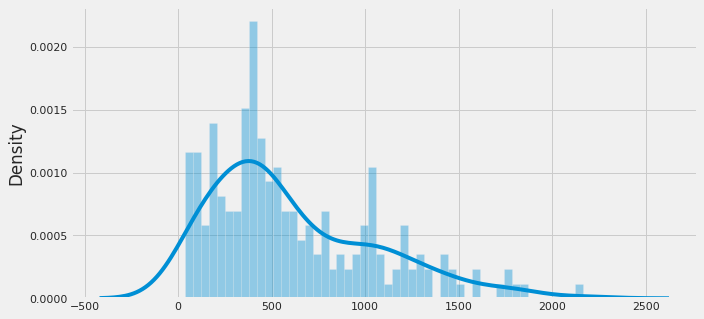

In [34]:
plt.figure(figsize=(10,5))
sns.distplot(proc_statement_df["word_count"].values, bins=50)

### Split contents to max 200 words

In [35]:
split_statement_df = get_split_df(proc_statement_df)
split_statement_df.tail(10)


          type  ...                                                                                                                                                                                                 org_text
0    statement  ...  \n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to ...
1    statement  ...  \n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to...
2    statement  ...  \n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with ...
3    statement  ...  \n\n[SECTION]\n\nThe Federal Reserve today announced two actions designed to maintain favorabl

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
854,statement,2020-07-29,FOMC Statement,Jerome Powell,78,<NA>,None,2020-08-27,<NA>,None,and businesses over coming months the Federal Reserve will increase its holdings of Treasury securities and agency residential and commercial mortgage backed securities at least at the current pac...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."
855,statement,2020-08-27,FOMC Statement,Jerome Powell,200,<NA>,None,2020-09-16,<NA>,None,Following an extensive review that included numerous public events across the country the Federal Open Market Committee FOMC on Thursday announced the unanimous approval of updates to its Statemen...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."
856,statement,2020-08-27,FOMC Statement,Jerome Powell,200,<NA>,None,2020-09-16,<NA>,None,market can be sustained without causing an unwelcome increase in inflation This first public review of the FOMC framework was announced by Chair Powell in November and involved three distinct comp...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."
857,statement,2020-08-27,FOMC Statement,Jerome Powell,87,<NA>,None,2020-09-16,<NA>,None,communications htm Finally the Committee explored the range of issues that were brought to light during the course of the review in five consecutive meetings beginning in July Analytical staff wor...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."
858,statement,2020-09-16,FOMC Statement,Jerome Powell,200,<NA>,None,2020-11-05,<NA>,None,The COVID pandemic is causing tremendous human and economic hardship across the United States and around the world Economic activity and employment have picked up in recent months but remain well ...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."
859,statement,2020-09-16,FOMC Statement,Jerome Powell,200,<NA>,None,2020-11-05,<NA>,None,these outcomes are achieved The Committee decided to keep the target range for the federal funds rate at to percent and expects it will be appropriate to maintain this target range until labor mar...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and fina

### Filter out by keywords

In [36]:
# Keep sections having keywords and long enough
keyword_statement_df = remove_short_nokeyword(proc_statement_df)
keyword_statement_df.reset_index(drop=True, inplace=True)
print(keyword_statement_df.shape)
keyword_statement_df


(108, 13)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,statement,1994-05-17,FOMC Statement,Alan Greenspan,38,<NA>,None,1994-07-06,<NA>,None,"The Board approved an increase in the discount rate from 3 percent to 3-1/2 percent, effective immediately, and the Federal Open Market Committee agreed that this increase should be allowed to sho...","[The Board approved an increase in the discount rate from 3 percent to 3-1/2 percent, effective immediately, and the Federal Open Market Committee agreed that this increase should be allowed to sh...",\n\n[SECTION]\n\nThe Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion.\n\n[SECTION]\n\nThe Board approved a...
1,statement,1994-11-15,FOMC Statement,Alan Greenspan,27,<NA>,None,1994-12-20,<NA>,None,"In a related move, the Federal Open Market Committee decided that the increase in the discount rate should be reflected fully in interest rates in reserve markets.","[In a related move, the Federal Open Market Committee decided that the increase in the discount rate should be reflected fully in interest rates in reserve markets.]","\n\n[SECTION]\n\nThe Federal Reserve Board today approved an increase in the discount rate from 4 percent to 4 3/4 percent, effective immediately.\n\n[SECTION]\n\nIn a related move, the Federal Op..."
2,statement,1996-01-31,FOMC Statement,Alan Greenspan,391,<NA>,None,1996-03-26,<NA>,None,"For immediate releaseThe Federal Reserve today announced the following policy actions:The Board of Governors approved a reduction in the discount rate from 5-1/4 percent to 5 percent, effective im...","[For immediate releaseThe Federal Reserve today announced the following policy actions:The Board of Governors approved a reduction in the discount rate from 5-1/4 percent to 5 percent, effective i...",For immediate release\n\n\n\n\n\n\r\n\r\nThe Federal Reserve today announced the following policy \r\nactions:\r\n\r\n\nThe Board of Governors approved a reduction in the discount rate from \r\n5-...
3,statement,1997-03-25,FOMC Statement,Alan Greenspan,405,<NA>,None,1997-05-20,<NA>,None,"For immediate release\tThe Federal Open Market Committee decided today to tighten money market conditions slightly, expecting the federal funds rate to rise 1/4 percentage point to around 5-1/2 pe...","[For immediate release\tThe Federal Open Market Committee decided today to tighten money market conditions slightly, expecting the federal funds rate to rise 1/4 percentage point to around 5-1/2 p...","For immediate release\n\n\n\n\n\n\r\n\r\n\tThe Federal Open Market Committee decided today to tighten money market conditions slightly, expecting the federal funds rate to rise 1/4 percentage poin..."
4,statement,1998-09-29,FOMC Statement,Alan Greenspan,373,<NA>,None,1998-10-15,<NA>,None,"For immediate releaseThe Federal Open Market Committee decided today to ease the stance of monetary policy slightly, expecting the federal funds rate to decline 1/4 percentage point to around 5-1/...","[For immediate releaseThe Federal Open Market Committee decided today to ease the stance of monetary policy slightly, expecting the federal funds rate to decline 1/4 percentage point to around 5-1...","For immediate release\n\n\n\n\n\n\r\nThe Federal Open Market Committee decided today to ease the stance of monetary policy slightly, expecting the federal funds rate to decline 1/4 percentage poin..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,statement,2020-04-29,FOMC Statement,Jerome Powell,83,<NA>,None,2020-06-10,<NA>,None,"The ongoing public health crisis will weigh heavily on economic activity, employment, and inflation in the near term, and poses considerable risks to the economic outlook over the medium term. In ...","[The ongoing public health crisis will weigh heavily on economic activity, employment, and inflation in the near term, and poses considerable ri

In [37]:
# Drop text during the process to reduce the output size
proc_statement_df.drop(columns=['text_sections', 'org_text'], inplace=True)
split_statement_df.drop(columns=['text_sections', 'org_text'], inplace=True)
keyword_statement_df.drop(columns=['text_sections', 'org_text'], inplace=True)

## Minutes DataFrame

In [38]:
minutes_df.head()

,date,contents,speaker,title
0,1993-02-03,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, February 2, 1993, at...",Alan Greenspan,FOMC Meeting Minutes
1,1993-03-23,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, March 23, 1993, a...",Alan Greenspan,FOMC Meeting Minutes
2,1993-05-18,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, May 18, 1993, at ...",Alan Greenspan,FOMC Meeting Minutes
3,1993-07-07,"A meeting of the Federal Open Market Committee was held in the \r\n offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, July 6, 1993, at 2:3...",Alan Greenspan,FOMC Meeting Minutes
4,1993-08-17,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, August 17, 1993, at ...",Alan Greenspan,FOMC Meeting Minutes


In [39]:
# Reorganize the dataframe
proc_minutes_df = reorganize_df(minutes_df, 'minutes')

No rate decision found:  229
Shape of the dataframe:  (229, 13)


In [40]:
# Check the returned dataframe
proc_minutes_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,minutes,1993-02-03,FOMC Meeting Minutes,Alan Greenspan,10241,<NA>,None,1993-02-18,<NA>,None,"A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, February 2, 1993, at 2:30 p....","[A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, February 2, 1993, at 2:30 p...","A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, February 2, 1993, at..."
1,minutes,1993-03-23,FOMC Meeting Minutes,Alan Greenspan,5792,<NA>,None,1993-05-18,<NA>,None,"A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, March 23, 1993, at 9:00 ...","[A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, March 23, 1993, at 9:00...","A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, March 23, 1993, a..."
2,minutes,1993-05-18,FOMC Meeting Minutes,Alan Greenspan,5001,<NA>,None,1993-07-07,<NA>,None,"A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, May 18, 1993, at 9:00 a....","[A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, May 18, 1993, at 9:00 a...","A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, May 18, 1993, at ..."
3,minutes,1993-07-07,FOMC Meeting Minutes,Alan Greenspan,7064,<NA>,None,1993-08-17,<NA>,None,"A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, July 6, 1993, at 2:30 p.m. a...","[A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, July 6, 1993, at 2:30 p.m. ...","A meeting of the Federal Open Market Committee was held in the \r\n offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, July 6, 1993, at 2:3..."
4,minutes,1993-08-17,FOMC Meeting Minutes,Alan Greenspan,4679,<NA>,None,1993-09-21,<NA>,None,"A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, August 17, 1993, at 9:00 a.m...","[A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, August 17, 1993, at 9:00 a....","A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, August 17, 1993, at ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,minutes,2020-03-15,FOMC Meeting Minutes,Jerome Powell,9953,<NA>,None,2020-03-19,<NA>,None,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.[SECTION]Federal Open Market Committee[SECTION]Monet...","[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market C

In [41]:
# Check which row does not have rate
proc_minutes_df.loc[proc_minutes_df['rate'].isnull()]

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,minutes,1993-02-03,FOMC Meeting Minutes,Alan Greenspan,10241,<NA>,None,1993-02-18,<NA>,None,"A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, February 2, 1993, at 2:30 p....","[A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, February 2, 1993, at 2:30 p...","A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, February 2, 1993, at..."
1,minutes,1993-03-23,FOMC Meeting Minutes,Alan Greenspan,5792,<NA>,None,1993-05-18,<NA>,None,"A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, March 23, 1993, at 9:00 ...","[A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, March 23, 1993, at 9:00...","A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, March 23, 1993, a..."
2,minutes,1993-05-18,FOMC Meeting Minutes,Alan Greenspan,5001,<NA>,None,1993-07-07,<NA>,None,"A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, May 18, 1993, at 9:00 a....","[A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, May 18, 1993, at 9:00 a...","A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, May 18, 1993, at ..."
3,minutes,1993-07-07,FOMC Meeting Minutes,Alan Greenspan,7064,<NA>,None,1993-08-17,<NA>,None,"A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, July 6, 1993, at 2:30 p.m. a...","[A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, July 6, 1993, at 2:30 p.m. ...","A meeting of the Federal Open Market Committee was held in the \r\n offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, July 6, 1993, at 2:3..."
4,minutes,1993-08-17,FOMC Meeting Minutes,Alan Greenspan,4679,<NA>,None,1993-09-21,<NA>,None,"A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, August 17, 1993, at 9:00 a.m...","[A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, August 17, 1993, at 9:00 a....","A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, August 17, 1993, at ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,minutes,2020-03-15,FOMC Meeting Minutes,Jerome Powell,9953,<NA>,None,2020-03-19,<NA>,None,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.[SECTION]Federal Open Market Committee[SECTION]Monet...","[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market C

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


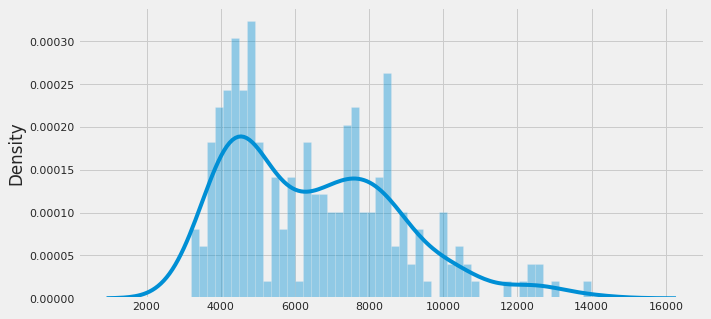

In [42]:
plt.figure(figsize=(10,5))
sns.distplot(proc_minutes_df["word_count"].values, bins=50)

In [43]:
# Check which row does not have rate
proc_minutes_df.loc[proc_minutes_df['rate'].isnull()]

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,minutes,1993-02-03,FOMC Meeting Minutes,Alan Greenspan,10241,<NA>,None,1993-02-18,<NA>,None,"A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, February 2, 1993, at 2:30 p....","[A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, February 2, 1993, at 2:30 p...","A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, February 2, 1993, at..."
1,minutes,1993-03-23,FOMC Meeting Minutes,Alan Greenspan,5792,<NA>,None,1993-05-18,<NA>,None,"A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, March 23, 1993, at 9:00 ...","[A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, March 23, 1993, at 9:00...","A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, March 23, 1993, a..."
2,minutes,1993-05-18,FOMC Meeting Minutes,Alan Greenspan,5001,<NA>,None,1993-07-07,<NA>,None,"A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, May 18, 1993, at 9:00 a....","[A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, May 18, 1993, at 9:00 a...","A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, May 18, 1993, at ..."
3,minutes,1993-07-07,FOMC Meeting Minutes,Alan Greenspan,7064,<NA>,None,1993-08-17,<NA>,None,"A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, July 6, 1993, at 2:30 p.m. a...","[A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, July 6, 1993, at 2:30 p.m. ...","A meeting of the Federal Open Market Committee was held in the \r\n offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, July 6, 1993, at 2:3..."
4,minutes,1993-08-17,FOMC Meeting Minutes,Alan Greenspan,4679,<NA>,None,1993-09-21,<NA>,None,"A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, August 17, 1993, at 9:00 a.m...","[A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, August 17, 1993, at 9:00 a....","A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, August 17, 1993, at ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,minutes,2020-03-15,FOMC Meeting Minutes,Jerome Powell,9953,<NA>,None,2020-03-19,<NA>,None,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.[SECTION]Federal Open Market Committee[SECTION]Monet...","[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market C

Meeting minutes includes various topics, so it makes sense to extract relevant sections. <br />
Check some common sections.

In [44]:
# Check what kind of sections are in common

a = minutes_df.contents.str.lower().str.count('staff economic outlook')
b = minutes_df.contents.str.lower().str.count('developments in financial markets')
c = minutes_df.contents.str.lower().str.count('staff review of the economic situation')
d = minutes_df.contents.str.lower().str.count('staff review of the financial situation')
e = minutes_df.contents.str.lower().str.count('participants\' views on current condition')
f = minutes_df.contents.str.lower().str.count('committee policy action')
g = minutes_df.contents.str.lower().str.count('voting for this action')
h = minutes_df.contents.str.lower().str.count('federal fund')

pd.options.display.max_rows = 300
pd.DataFrame({'date': minutes_df['date'], 'a': a, 'b':b, 'c':c, 'd':d, 'e':e, 'f':f, 'g':g, 'h':h})

,date,a,b,c,d,e,f,g,h
0,1993-02-03,0,0,0,0,0,0,0,1
1,1993-03-23,0,0,0,0,0,0,0,3
2,1993-05-18,0,0,0,0,0,0,0,1
3,1993-07-07,0,0,0,0,0,0,0,3
4,1993-08-17,0,0,0,0,0,0,0,1
5,1993-09-21,0,0,0,0,0,0,0,1
6,1993-11-16,0,0,0,0,0,0,0,1
7,1993-12-21,0,0,0,0,0,0,0,2
8,1994-02-04,0,1,0,0,0,0,0,0
9,1994-03-22,0,0,0,0,0,0,0,2


In [45]:
pd.options.display.max_rows = 20

Sections are added from time to time. For example, quarterly economic forcast started in 2009. Leave manually handling those for now, take another approach to filter sentenses by length and key words here.

In [46]:
proc_minutes_df = remove_short_section(proc_minutes_df, min_words=50)

### Split contents to max 200 words

In [47]:
split_minutes_df = get_split_df(proc_minutes_df)
print(split_minutes_df.shape)
split_minutes_df.tail(10)


         type  ...                                                                                                                                                                                                 org_text
0     minutes  ...  A meeting of the Federal Open Market Committee was held in \r\n    the offices of the Board of Governors of the Federal Reserve System in \r\n    Washington, D.C., on Tuesday, February 2, 1993, at...
1     minutes  ...  A meeting of the Federal Open Market Committee was held in \r\n    the offices of the Board of Governors of the Federal Reserve System in \r\n    Washington, D.C., on Tuesday, February 2, 1993, at...
2     minutes  ...  A meeting of the Federal Open Market Committee was held in \r\n    the offices of the Board of Governors of the Federal Reserve System in \r\n    Washington, D.C., on Tuesday, February 2, 1993, at...
3     minutes  ...  A meeting of the Federal Open Market Committee was held in \r\n    the offices of the Board of Gove

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
8527,minutes,2020-09-16,FOMC Meeting Minutes,Jerome Powell,200,<NA>,None,2020-11-05,<NA>,None,at the current pace These actions would continue to help sustain smooth market functioning and would continue to help foster accommodative financial conditions thereby supporting the flow of credi...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."
8528,minutes,2020-09-16,FOMC Meeting Minutes,Jerome Powell,200,<NA>,None,2020-11-05,<NA>,None,in part reflecting policy measures to support the economy and the flow of credit to U S households and businesses Members agreed that the Federal Reserve was committed to using its full range of t...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."
8529,minutes,2020-09-16,FOMC Meeting Minutes,Jerome Powell,200,<NA>,None,2020-11-05,<NA>,None,in the new consensus statement in pursuit of the Committee's statutory objectives Accordingly members agreed that the FOMC statement should note that the Committee seeks to achieve maximum employm...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."
8530,minutes,2020-09-16,FOMC Meeting Minutes,Jerome Powell,200,<NA>,None,2020-11-05,<NA>,None,all members agreed on a specification for outcome based forward guidance that indicated that the Committee expects that it will be appropriate to maintain the current setting of the target range f...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."
8531,minutes,2020-09-16,FOMC Meeting Minutes,Jerome Powell,200,<NA>,None,2020-11-05,<NA>,None,a stronger formulation for the forward one in which the Committee would indicate that it expected to maintain the current target range until core inflation had reached percent on a sustained basis...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, Monetary Policy Pr...","The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S..."
8532,minutes,2020-09-16,FOMC Meeting Minutes,Jerome Powell,200,<NA>,None,2020-11-05,<NA>,None,including readings on public health labor market conditions inflation pressures and inflation expectations and financial and international developments Members noted that the Committee's asset pur...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexib

### Filter out by keywords

In [48]:
# Keep sections having keywords and long enough
keyword_minutes_df = remove_short_nokeyword(proc_minutes_df)
keyword_minutes_df.reset_index(drop=True, inplace=True)
print(keyword_minutes_df.shape)
keyword_minutes_df


(229, 13)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,minutes,1993-02-03,FOMC Meeting Minutes,Alan Greenspan,2119,<NA>,None,1993-02-18,<NA>,None,"The nominal U.S. merchandise trade deficit widened slightly in November. For October and November together, however, the deficit narrowed a little from its average rate in the third quarte...","[The nominal U.S. merchandise trade deficit widened slightly in November. For October and November together, however, the deficit narrowed a little from its average rate in the third quart...","A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, February 2, 1993, at..."
1,minutes,1993-03-23,FOMC Meeting Minutes,Alan Greenspan,1770,<NA>,None,1993-05-18,<NA>,None,"In foreign exchange markets, the trade-weighted value of the dollar in terms of the other G-10 currencies fell on balance over the intermeeting period. The dollar depreciated through late ...","[In foreign exchange markets, the trade-weighted value of the dollar in terms of the other G-10 currencies fell on balance over the intermeeting period. The dollar depreciated through late...","A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, March 23, 1993, a..."
2,minutes,1993-05-18,FOMC Meeting Minutes,Alan Greenspan,1182,<NA>,None,1993-07-07,<NA>,None,"In foreign exchange markets, the trade-weighted value of the dollar in terms of the other G-10 currencies declined somewhat on balance over the intermeeting period. The dollar depreciated ...","[In foreign exchange markets, the trade-weighted value of the dollar in terms of the other G-10 currencies declined somewhat on balance over the intermeeting period. The dollar depreciated...","A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, May 18, 1993, at ..."
3,minutes,1993-07-07,FOMC Meeting Minutes,Alan Greenspan,2636,<NA>,None,1993-08-17,<NA>,None,"Other short-term interest rates also were little changed on balance over the period since the May meeting. Early in the period, unexpectedly robust employment data for May, coupled with me...","[Other short-term interest rates also were little changed on balance over the period since the May meeting. Early in the period, unexpectedly robust employment data for May, coupled with m...","A meeting of the Federal Open Market Committee was held in the \r\n offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, July 6, 1993, at 2:3..."
4,minutes,1993-08-17,FOMC Meeting Minutes,Alan Greenspan,1272,<NA>,None,1993-09-21,<NA>,None,"Money market interest rates were little changed on balance over the intermeeting period, while rates on intermediate-term U.S. Treasury obligations and on fixed-rate mortgages dropped slig...","[Money market interest rates were little changed on balance over the intermeeting period, while rates on intermediate-term U.S. Treasury obligations and on fixed-rate mortgages dropped sli...","A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, August 17, 1993, at ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,minutes,2020-03-15,FOMC Meeting Minutes,Jerome Powell,2280,<NA>,None,2020-03-19,<NA>,None,Developments in Financial Markets and Open Market OperationsThe System Open Market Account (SOMA) manager first reviewed developments in domestic and global financial markets. Financial markets re...,[Developments in Financial Markets and Open Market OperationsThe System Open Market Account (SOMA) manager first reviewed developments in domestic and globa

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


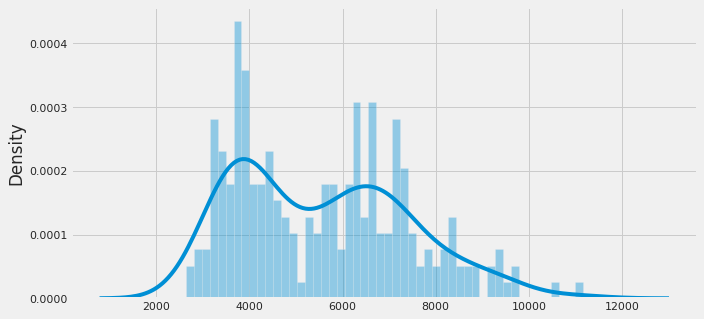

In [49]:
plt.figure(figsize=(10,5))
sns.distplot(proc_minutes_df["word_count"].values, bins=50)

In [50]:
# Drop text during the process to reduce the output size
proc_minutes_df.drop(columns=['text_sections', 'org_text'], inplace=True)
split_minutes_df.drop(columns=['text_sections', 'org_text'], inplace=True)
keyword_minutes_df.drop(columns=['text_sections', 'org_text'], inplace=True)

## Press Conference Script DataFrame
Press Conference transcripts are available only from 2011

In [51]:
# Sample
print(presconf_script_df['contents'][2])

Thank you for your patience, and I would be happy to take your questions.

[SECTION]

policy, in your opinion?

[SECTION]

at least, not proved to be very valid.

[SECTION]

STEVE LIESMAN. Was the letter appropriate?

[SECTION]

going to do.

[SECTION]

And what are your views on the advantages and disadvantages of that approach?

[SECTION]

date—at this time—any radical change in framework. We are going to stay within the dualmandate approach that we’ve been using until this point.

[SECTION]

economy?

[SECTION]

address inequality per se.

[SECTION]

how people should interpret those two messages?

[SECTION]

necessarily move in mid-2013 with those conditions prevailing that you described.

[SECTION]

proposal?

[SECTION]

conditions were appropriate. So the answer is yes, we would certainly look at that.

[SECTION]

know that U.S. companies don’t about investing in the U.S.?

[SECTION]

but it’s still obviously too low to be consistent with a full employment economy.

[SECTION]

th

In [52]:
# Reorganize the dataframe
proc_presconf_script_df = reorganize_df(presconf_script_df, 'press_conference')


No rate decision found:  47
Shape of the dataframe:  (47, 13)


In [53]:
# Check the returned dataframe
proc_presconf_script_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,press_conference,2011-04-27,FOMC Press Conference Transcript,Ben Bernanke,8761,<NA>,None,2011-06-22,<NA>,None,"CHAIRMAN BERNANKE. Good afternoon. Welcome.In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll thenturn next to the Federal Open Market Committee’s quarterly econ...","[CHAIRMAN BERNANKE. Good afternoon. Welcome.In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll thenturn next to the Federal Open Market Committee’s quarterly eco...","CHAIRMAN BERNANKE. Good afternoon. Welcome.\rIn my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then\rturn next to the Federal Open Market Committee’s quarterly ..."
1,press_conference,2011-06-22,FOMC Press Conference Transcript,Ben Bernanke,7363,<NA>,None,2011-08-01,<NA>,None,"CHAIRMAN BERNANKE. Good afternoon and welcome.In my opening remarks today, I’ll briefly review today’s policy decision. And I’ll placethe decision in the context of our economic projections and ou...","[CHAIRMAN BERNANKE. Good afternoon and welcome.In my opening remarks today, I’ll briefly review today’s policy decision. And I’ll placethe decision in the context of our economic projections and o...","CHAIRMAN BERNANKE. Good afternoon and welcome.\rIn my opening remarks today, I’ll briefly review today’s policy decision. And I’ll place\rthe decision in the context of our economic projections an..."
2,press_conference,2011-11-02,FOMC Press Conference Transcript,Ben Bernanke,7358,<NA>,None,2011-11-28,<NA>,None,"CHAIRMAN BERNANKE. Good afternoon, everybody. Welcome.In my opening remarks, I will briefly review today’s policy decision of the Federal Openour policy strategy. I will then be glad to take your ...","[CHAIRMAN BERNANKE. Good afternoon, everybody. Welcome.In my opening remarks, I will briefly review today’s policy decision of the Federal Openour policy strategy. I will then be glad to take your...","CHAIRMAN BERNANKE. Good afternoon, everybody. Welcome.\rIn my opening remarks, I will briefly review today’s policy decision of the Federal Open\rour policy strategy. I will then be glad to take y..."
3,press_conference,2012-01-25,FOMC Press Conference Transcript,Ben Bernanke,10134,<NA>,None,2012-03-13,<NA>,None,CHAIRMAN BERNANKE. Good afternoon and welcome.In my opening remarks I will briefly review today’s policy decision by the Federal Opento you regarding the Committee’s longer-run policy goals and st...,[CHAIRMAN BERNANKE. Good afternoon and welcome.In my opening remarks I will briefly review today’s policy decision by the Federal Opento you regarding the Committee’s longer-run policy goals and s...,CHAIRMAN BERNANKE. Good afternoon and welcome.\rIn my opening remarks I will briefly review today’s policy decision by the Federal Open\rto you regarding the Committee’s longer-run policy goals an...
4,press_conference,2012-04-25,FOMC Press Conference Transcript,Ben Bernanke,7678,<NA>,None,2012-06-20,<NA>,None,"CHAIRMAN BERNANKE. Good afternoon. Before we get to questions, I’ll summarizetoday’s policy action by the Federal Open Market Committee and then I’ll place the Committee’spolicy decision in the co...","[CHAIRMAN BERNANKE. Good afternoon. Before we get to questions, I’ll summarizetoday’s policy action by the Federal Open Market Committee and then I’ll place the Committee’spolicy decision in the c...","CHAIRMAN BERNANKE. Good afternoon. Before we get to questions, I’ll summarize\rtoday’s policy action by the Federal Open Market Committee and then I’ll place the Committee’s\rpolicy decision in th..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42,press_conference,2020-04-29,FOMC Press Conference Transcript,Jerome Powell,8211,<NA>,None,2020-06-10,<NA>,None,CHAIR POWELL. Good afternoon. Thanks for joining us today. I would like to beginby acknowledging the tragic loss and tremendous ha

In [54]:
# Check which row does not have rate
proc_presconf_script_df.loc[proc_presconf_script_df['rate'].isnull()]

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,press_conference,2011-04-27,FOMC Press Conference Transcript,Ben Bernanke,8761,<NA>,None,2011-06-22,<NA>,None,"CHAIRMAN BERNANKE. Good afternoon. Welcome.In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll thenturn next to the Federal Open Market Committee’s quarterly econ...","[CHAIRMAN BERNANKE. Good afternoon. Welcome.In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll thenturn next to the Federal Open Market Committee’s quarterly eco...","CHAIRMAN BERNANKE. Good afternoon. Welcome.\rIn my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then\rturn next to the Federal Open Market Committee’s quarterly ..."
1,press_conference,2011-06-22,FOMC Press Conference Transcript,Ben Bernanke,7363,<NA>,None,2011-08-01,<NA>,None,"CHAIRMAN BERNANKE. Good afternoon and welcome.In my opening remarks today, I’ll briefly review today’s policy decision. And I’ll placethe decision in the context of our economic projections and ou...","[CHAIRMAN BERNANKE. Good afternoon and welcome.In my opening remarks today, I’ll briefly review today’s policy decision. And I’ll placethe decision in the context of our economic projections and o...","CHAIRMAN BERNANKE. Good afternoon and welcome.\rIn my opening remarks today, I’ll briefly review today’s policy decision. And I’ll place\rthe decision in the context of our economic projections an..."
2,press_conference,2011-11-02,FOMC Press Conference Transcript,Ben Bernanke,7358,<NA>,None,2011-11-28,<NA>,None,"CHAIRMAN BERNANKE. Good afternoon, everybody. Welcome.In my opening remarks, I will briefly review today’s policy decision of the Federal Openour policy strategy. I will then be glad to take your ...","[CHAIRMAN BERNANKE. Good afternoon, everybody. Welcome.In my opening remarks, I will briefly review today’s policy decision of the Federal Openour policy strategy. I will then be glad to take your...","CHAIRMAN BERNANKE. Good afternoon, everybody. Welcome.\rIn my opening remarks, I will briefly review today’s policy decision of the Federal Open\rour policy strategy. I will then be glad to take y..."
3,press_conference,2012-01-25,FOMC Press Conference Transcript,Ben Bernanke,10134,<NA>,None,2012-03-13,<NA>,None,CHAIRMAN BERNANKE. Good afternoon and welcome.In my opening remarks I will briefly review today’s policy decision by the Federal Opento you regarding the Committee’s longer-run policy goals and st...,[CHAIRMAN BERNANKE. Good afternoon and welcome.In my opening remarks I will briefly review today’s policy decision by the Federal Opento you regarding the Committee’s longer-run policy goals and s...,CHAIRMAN BERNANKE. Good afternoon and welcome.\rIn my opening remarks I will briefly review today’s policy decision by the Federal Open\rto you regarding the Committee’s longer-run policy goals an...
4,press_conference,2012-04-25,FOMC Press Conference Transcript,Ben Bernanke,7678,<NA>,None,2012-06-20,<NA>,None,"CHAIRMAN BERNANKE. Good afternoon. Before we get to questions, I’ll summarizetoday’s policy action by the Federal Open Market Committee and then I’ll place the Committee’spolicy decision in the co...","[CHAIRMAN BERNANKE. Good afternoon. Before we get to questions, I’ll summarizetoday’s policy action by the Federal Open Market Committee and then I’ll place the Committee’spolicy decision in the c...","CHAIRMAN BERNANKE. Good afternoon. Before we get to questions, I’ll summarize\rtoday’s policy action by the Federal Open Market Committee and then I’ll place the Committee’s\rpolicy decision in th..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42,press_conference,2020-04-29,FOMC Press Conference Transcript,Jerome Powell,8211,<NA>,None,2020-06-10,<NA>,None,CHAIR POWELL. Good afternoon. Thanks for joining us today. I would like to beginby acknowledging the tragic loss and tremendous ha

### Split by speakers
Scripts contain words from different people, so split by the speaker

In [55]:
script_data_list = []

for i, row in tqdm(proc_presconf_script_df.iterrows()):
    for text in row["text_sections"]:
        match = re.findall(r'(^[A-Za-zŞ. ]*[A-Z]{3}).\d? (.*)', text)
        if len(match) == 0:
            match = re.findall(r'(^[A-Za-zŞ. ]*[A-Z]{3}).\d(.*)', text)
            if len(match) == 0:
                print("not matched: ", text)
                print(row['date'])
                print()
        if len(match) == 1:
            speaker, text = match[0]
            row['speaker'] = speaker
            row['text'] = text
            row['word_count'] = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text))
            script_data_list.append(list(row))

col_name = proc_presconf_script_df.columns

presconf_script_speaker_df = pd.DataFrame(script_data_list, columns = col_name)
presconf_script_speaker_df

not matched:  PRELIMINARYTranscript of Chair Powell’s Press Conference
2020-11-05 00:00:00

not matched:  PRELIMINARYAlthough we welcome this progress, we will not lose sight of the millions of Americans whoremain out of work. The economic downturn has not fallen equally on all Americans, and thoseleast able to shoulder the burden have been hardest hit. In particular, the high level ofjoblessness has been especially severe for lower-wage workers in the services sector, for women,and for African Americans and Hispanics. The economic dislocation has upended many livesand created great uncertainty about the future.The pandemic has also left a significant imprint on inflation. Following large declines inthe spring, consumer prices picked up over the summer, in part reflecting a rise in durable goodsprices. However, for those sectors that have been most affected by the pandemic, prices remainparticularly soft. Overall, on a 12-month basis, inflation remains below our 2 percent longer-runobj

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,press_conference,2011-04-27,FOMC Press Conference Transcript,CHAIRMAN BERNANKE,1509,<NA>,None,2011-06-22,<NA>,None,"Good afternoon. Welcome.In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll thenturn next to the Federal Open Market Committee’s quarterly economic projections al...","[CHAIRMAN BERNANKE. Good afternoon. Welcome.In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll thenturn next to the Federal Open Market Committee’s quarterly eco...","CHAIRMAN BERNANKE. Good afternoon. Welcome.\rIn my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then\rturn next to the Federal Open Market Committee’s quarterly ..."
1,press_conference,2011-04-27,FOMC Press Conference Transcript,QUESTION,61,<NA>,None,2011-06-22,<NA>,None,"Mr. Chairman, tomorrow we’re going to get a pretty weak first-quarterGDP number. Your own projections for the year have been downgraded in this meeting. How—first of all, what do you see as the ca...","[CHAIRMAN BERNANKE. Good afternoon. Welcome.In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll thenturn next to the Federal Open Market Committee’s quarterly eco...","CHAIRMAN BERNANKE. Good afternoon. Welcome.\rIn my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then\rturn next to the Federal Open Market Committee’s quarterly ..."
2,press_conference,2011-04-27,FOMC Press Conference Transcript,CHAIRMAN BERNANKE,185,<NA>,None,2011-06-22,<NA>,None,"You’re correct. We haven’t seen the GDP number yet. Butwe, like most private-sector forecasters, are expecting a relatively weak number for the firstquarter, maybe something a little under 2 perce...","[CHAIRMAN BERNANKE. Good afternoon. Welcome.In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll thenturn next to the Federal Open Market Committee’s quarterly eco...","CHAIRMAN BERNANKE. Good afternoon. Welcome.\rIn my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then\rturn next to the Federal Open Market Committee’s quarterly ..."
3,press_conference,2011-04-27,FOMC Press Conference Transcript,QUESTION,55,<NA>,None,2011-06-22,<NA>,None,"Mr. Chairman, given what you know about the pace of the economy now,what is your best guess for how soon the Fed needs to begin to withdraw its extraordinarystimulus for the economy? And could you...","[CHAIRMAN BERNANKE. Good afternoon. Welcome.In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll thenturn next to the Federal Open Market Committee’s quarterly eco...","CHAIRMAN BERNANKE. Good afternoon. Welcome.\rIn my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then\rturn next to the Federal Open Market Committee’s quarterly ..."
4,press_conference,2011-04-27,FOMC Press Conference Transcript,CHAIRMAN BERNANKE,303,<NA>,None,2011-06-22,<NA>,None,"Well, currently as the statement suggests, we are in amoderate recovery. We’ll be looking very carefully, first, to see if that recovery is, indeed,sustainable, as we believe it is. And we’ll also...","[CHAIRMAN BERNANKE. Good afternoon. Welcome.In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll thenturn next to the Federal Open Market Committee’s quarterly eco...","CHAIRMAN BERNANKE. Good afternoon. Welcome.\rIn my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then\rturn next to the Federal Open Market Committee’s quarterly ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2248,press_conference,2020-11-05,FOMC Press Conference Transcript,MICHAEL MCKEE,99,<NA>,None,2020-12-16,<NA>,None,"Mr. Chairman, there's a small but growing number of peopleincluding some former Fed economists who say you should find ways

In [56]:
# Filter by the word count
presconf_script_speaker_df = presconf_script_speaker_df.loc[presconf_script_speaker_df['word_count'] >= 50]

(1713, 13)


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


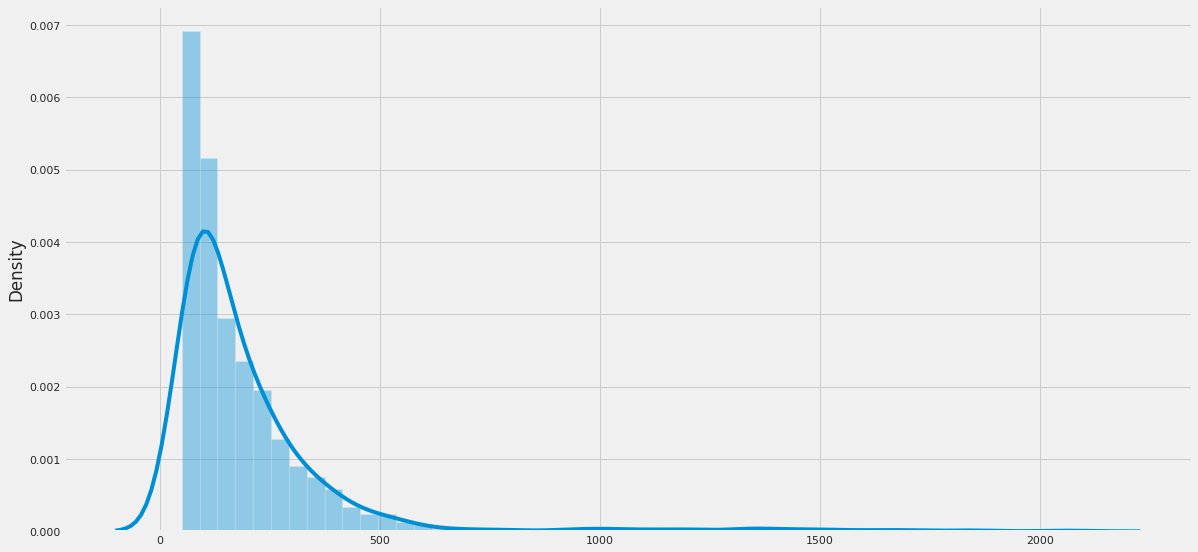

In [57]:
print(presconf_script_speaker_df.shape)
sns.distplot(presconf_script_speaker_df["word_count"].values, bins=50)

In [58]:
# Filter to have only chairperson's speak

tmp_list = []
for i, row in presconf_script_speaker_df.iterrows():
    chairperson = get_chairperson(row['date'])
    if chairperson.lower().split()[-1] in row['speaker'].lower():
        row['speaker'] = chairperson
        tmp_list.append(list(row))

col_names = presconf_script_speaker_df.columns
presconf_script_chair_df = pd.DataFrame(data=tmp_list, columns=col_names)
presconf_script_chair_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,press_conference,2011-04-27,FOMC Press Conference Transcript,Ben Bernanke,1509,<NA>,None,2011-06-22,<NA>,None,"Good afternoon. Welcome.In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll thenturn next to the Federal Open Market Committee’s quarterly economic projections al...","[CHAIRMAN BERNANKE. Good afternoon. Welcome.In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll thenturn next to the Federal Open Market Committee’s quarterly eco...","CHAIRMAN BERNANKE. Good afternoon. Welcome.\rIn my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then\rturn next to the Federal Open Market Committee’s quarterly ..."
1,press_conference,2011-04-27,FOMC Press Conference Transcript,Ben Bernanke,185,<NA>,None,2011-06-22,<NA>,None,"You’re correct. We haven’t seen the GDP number yet. Butwe, like most private-sector forecasters, are expecting a relatively weak number for the firstquarter, maybe something a little under 2 perce...","[CHAIRMAN BERNANKE. Good afternoon. Welcome.In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll thenturn next to the Federal Open Market Committee’s quarterly eco...","CHAIRMAN BERNANKE. Good afternoon. Welcome.\rIn my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then\rturn next to the Federal Open Market Committee’s quarterly ..."
2,press_conference,2011-04-27,FOMC Press Conference Transcript,Ben Bernanke,303,<NA>,None,2011-06-22,<NA>,None,"Well, currently as the statement suggests, we are in amoderate recovery. We’ll be looking very carefully, first, to see if that recovery is, indeed,sustainable, as we believe it is. And we’ll also...","[CHAIRMAN BERNANKE. Good afternoon. Welcome.In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll thenturn next to the Federal Open Market Committee’s quarterly eco...","CHAIRMAN BERNANKE. Good afternoon. Welcome.\rIn my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then\rturn next to the Federal Open Market Committee’s quarterly ..."
3,press_conference,2011-04-27,FOMC Press Conference Transcript,Ben Bernanke,197,<NA>,None,2011-06-22,<NA>,None,"Thanks, Steve. First, I should start by saying that theSecretary of the Treasury, of course, is the spokesperson for U.S. policy on the dollar andSecretary Geithner had some words yesterday. Let m...","[CHAIRMAN BERNANKE. Good afternoon. Welcome.In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll thenturn next to the Federal Open Market Committee’s quarterly eco...","CHAIRMAN BERNANKE. Good afternoon. Welcome.\rIn my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then\rturn next to the Federal Open Market Committee’s quarterly ..."
4,press_conference,2011-04-27,FOMC Press Conference Transcript,Ben Bernanke,158,<NA>,None,2011-06-22,<NA>,None,"Well, the dollar—the dollar fluctuates. One factor, forexample, that has caused fluctuations that have been quite extreme during the crisis has been thesafe-haven effect. So, for example, during t...","[CHAIRMAN BERNANKE. Good afternoon. Welcome.In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll thenturn next to the Federal Open Market Committee’s quarterly eco...","CHAIRMAN BERNANKE. Good afternoon. Welcome.\rIn my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then\rturn next to the Federal Open Market Committee’s quarterly ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1012,press_conference,2020-11-05,FOMC Press Conference Transcript,Jerome Powell,185,<NA>,None,2020-12-16,<NA>,None,"Thanks. So I'm very reluctant, as you will imagine, to comment onthe election directly, indirectly at all other than just to sa

In [59]:
# Combine scripts of the same speaker for the same day.
tmp_date = ''
tmp_speaker = ''
tmp_data = []

print('Before: ', presconf_script_chair_df.shape)

for i, row in tqdm(presconf_script_chair_df.iterrows()):
    if (row['date'] == tmp_date) and (row['speaker'] == tmp_speaker):
        tmp_data[-1]['text'] += row['text']
        tmp_data[-1]['word_count'] += row['word_count']
        tmp_data[-1]['text_sections'].append(row['text'])
    else:
        tmp_date = row['date']
        tmp_speaker = row['speaker']
        row['text_sections'] = [row['text']]
        tmp_data.append(row)

presconf_script_chair_day_df = pd.DataFrame(tmp_data)

print('After', presconf_script_chair_day_df.shape)
presconf_script_chair_day_df.head()

Before:  (1017, 13)



After (47, 13)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,press_conference,2011-04-27,FOMC Press Conference Transcript,Ben Bernanke,7047,<NA>,None,2011-06-22,<NA>,None,"Good afternoon. Welcome.In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll thenturn next to the Federal Open Market Committee’s quarterly economic projections al...","[Good afternoon. Welcome.In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll thenturn next to the Federal Open Market Committee’s quarterly economic projections a...","CHAIRMAN BERNANKE. Good afternoon. Welcome.\rIn my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then\rturn next to the Federal Open Market Committee’s quarterly ..."
21,press_conference,2011-06-22,FOMC Press Conference Transcript,Ben Bernanke,5635,<NA>,None,2011-08-01,<NA>,None,"Good afternoon and welcome.In my opening remarks today, I’ll briefly review today’s policy decision. And I’ll placethe decision in the context of our economic projections and our policy strategy. ...","[Good afternoon and welcome.In my opening remarks today, I’ll briefly review today’s policy decision. And I’ll placethe decision in the context of our economic projections and our policy strategy....","CHAIRMAN BERNANKE. Good afternoon and welcome.\rIn my opening remarks today, I’ll briefly review today’s policy decision. And I’ll place\rthe decision in the context of our economic projections an..."
40,press_conference,2011-11-02,FOMC Press Conference Transcript,Ben Bernanke,5519,<NA>,None,2011-11-28,<NA>,None,"Good afternoon, everybody. Welcome.In my opening remarks, I will briefly review today’s policy decision of the Federal Openour policy strategy. I will then be glad to take your questions.As indica...","[Good afternoon, everybody. Welcome.In my opening remarks, I will briefly review today’s policy decision of the Federal Openour policy strategy. I will then be glad to take your questions.As indic...","CHAIRMAN BERNANKE. Good afternoon, everybody. Welcome.\rIn my opening remarks, I will briefly review today’s policy decision of the Federal Open\rour policy strategy. I will then be glad to take y..."
62,press_conference,2012-01-25,FOMC Press Conference Transcript,Ben Bernanke,7488,<NA>,None,2012-03-13,<NA>,None,Good afternoon and welcome.In my opening remarks I will briefly review today’s policy decision by the Federal Opento you regarding the Committee’s longer-run policy goals and strategy. And finally...,[Good afternoon and welcome.In my opening remarks I will briefly review today’s policy decision by the Federal Opento you regarding the Committee’s longer-run policy goals and strategy. And finall...,CHAIRMAN BERNANKE. Good afternoon and welcome.\rIn my opening remarks I will briefly review today’s policy decision by the Federal Open\rto you regarding the Committee’s longer-run policy goals an...
81,press_conference,2012-04-25,FOMC Press Conference Transcript,Ben Bernanke,5453,<NA>,None,2012-06-20,<NA>,None,"Good afternoon. Before we get to questions, I’ll summarizetoday’s policy action by the Federal Open Market Committee and then I’ll place the Committee’spolicy decision in the context of our econom...","[Good afternoon. Before we get to questions, I’ll summarizetoday’s policy action by the Federal Open Market Committee and then I’ll place the Committee’spolicy decision in the context of our econo...","CHAIRMAN BERNANKE. Good afternoon. Before we get to questions, I’ll summarize\rtoday’s policy action by the Federal Open Market Committee and then I’ll place the Committee’s\rpolicy decision in th..."


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


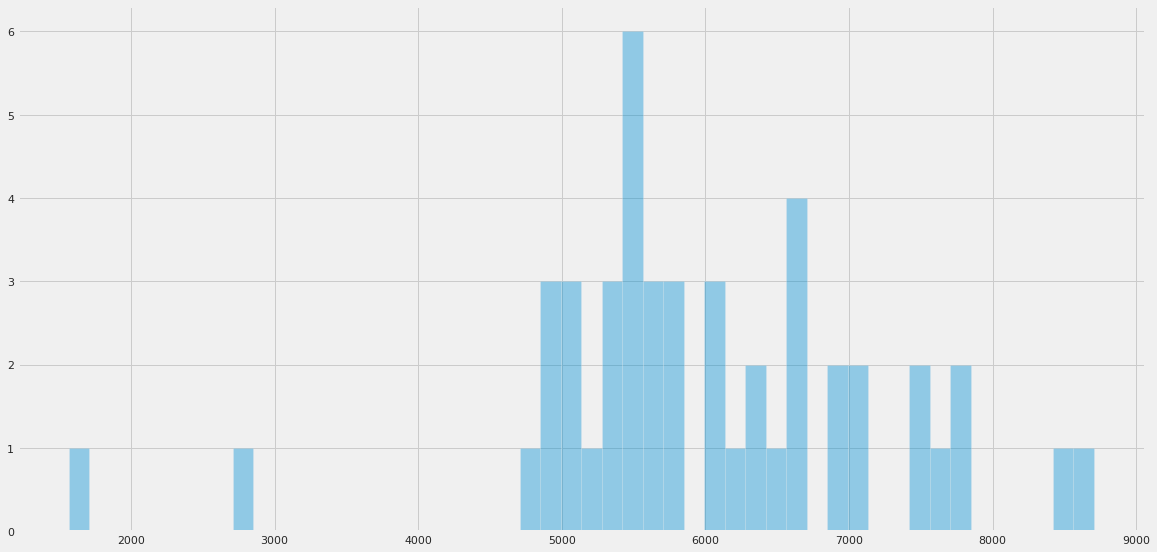

In [60]:
sns.distplot(list(presconf_script_chair_day_df['word_count']), bins=50, kde=False)

In [61]:
# # Check text
# print(presconf_script_chair_day_df['text'][0])

### Split contents to max 200 words

In [62]:
presconf_script_split_df = get_split_df(presconf_script_chair_day_df)
print(presconf_script_split_df.shape)
presconf_script_split_df.tail()


                  type  ...                                                                                                                                                                                                 org_text
0     press_conference  ...  CHAIRMAN BERNANKE. Good afternoon. Welcome.\rIn my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then\rturn next to the Federal Open Market Committee’s quarterly ...
1     press_conference  ...  CHAIRMAN BERNANKE. Good afternoon. Welcome.\rIn my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then\rturn next to the Federal Open Market Committee’s quarterly ...
2     press_conference  ...  CHAIRMAN BERNANKE. Good afternoon. Welcome.\rIn my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then\rturn next to the Federal Open Market Committee’s quarterly ...
3     press_conference  ...  CHAIRMAN BERNANKE. Good afternoon. Welcome.\rIn my ope

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
1875,press_conference,2020-11-05,FOMC Press Conference Transcript,Jerome Powell,200,<NA>,None,2020-12-16,<NA>,None,theprogram in a way it's the least thing we could do to redesign the program so that we couldmove to a lower level And it basically we concluded we could just change the fee structureto create inc...,"[Good afternoon.At the Federal Reserve, we are strongly committed to achieving the monetary policygoals that Congress has given us—maximum employment and price stability. Since thebeginning of the...","PRELIMINARY\r\rTranscript of Chair Powell’s Press Conference\r\n\n[SECTION]\n\nCHAIR POWELL. Good afternoon.\rAt the Federal Reserve, we are strongly committed to achieving the monetary policy\rgo..."
1876,press_conference,2020-11-05,FOMC Press Conference Transcript,Jerome Powell,200,<NA>,None,2020-12-16,<NA>,None,set of ones that we ve done And again wehope that it will help some companies and I guess we ll find out So when I say we re not out of ammo I m looking at you know acouple of our tools mainly As ...,"[Good afternoon.At the Federal Reserve, we are strongly committed to achieving the monetary policygoals that Congress has given us—maximum employment and price stability. Since thebeginning of the...","PRELIMINARY\r\rTranscript of Chair Powell’s Press Conference\r\n\n[SECTION]\n\nCHAIR POWELL. Good afternoon.\rAt the Federal Reserve, we are strongly committed to achieving the monetary policy\rgo..."
1877,press_conference,2020-11-05,FOMC Press Conference Transcript,Jerome Powell,200,<NA>,None,2020-12-16,<NA>,None,can do But remember we vealways said this will take a whole of government approach including healthcare policy and fiscalpolicy too So it really is if you want to get the economy back as quickly a...,"[Good afternoon.At the Federal Reserve, we are strongly committed to achieving the monetary policygoals that Congress has given us—maximum employment and price stability. Since thebeginning of the...","PRELIMINARY\r\rTranscript of Chair Powell’s Press Conference\r\n\n[SECTION]\n\nCHAIR POWELL. Good afternoon.\rAt the Federal Reserve, we are strongly committed to achieving the monetary policy\rgo..."
1878,press_conference,2020-11-05,FOMC Press Conference Transcript,Jerome Powell,200,<NA>,None,2020-12-16,<NA>,None,central bank is really funding fiscal activities of thegovernment fairly directly No That's not something we do We have different jobs Thatknow the job of taxation and spending goes to people who ...,"[Good afternoon.At the Federal Reserve, we are strongly committed to achieving the monetary policygoals that Congress has given us—maximum employment and price stability. Since thebeginning of the...","PRELIMINARY\r\rTranscript of Chair Powell’s Press Conference\r\n\n[SECTION]\n\nCHAIR POWELL. Good afternoon.\rAt the Federal Reserve, we are strongly committed to achieving the monetary policy\rgo..."
1879,press_conference,2020-11-05,FOMC Press Conference Transcript,Jerome Powell,71,<NA>,None,2020-12-16,<NA>,None,obligation You change the you change the youknow the nature of the obligation but not the total quantity of debt that the government has whenyou do these asset purchase programs So I don't know ex...,"[Good afternoon.At the Federal Reserve, we are strongly committed to achieving the monetary policygoals that Congress has given us—maximum employment and price stability. Since thebeginning of the...","PRELIMINARY\r\rTranscript of Chair Powell’s Press Conference\r\n\n[SECTION]\n\nCHAIR POWELL. Good afternoon.\rAt the Federal Reserve, we are strongly committed to achieving the monetary policy\rgo..."


### Filter out by keywords

In [63]:
# Keep sections having keywords and long enough
presconf_script_keyword_df = remove_short_nokeyword(presconf_script_chair_day_df)
presconf_script_keyword_df.reset_index(drop=True, inplace=True)
print(presconf_script_keyword_df.shape)
presconf_script_keyword_df


(47, 13)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,press_conference,2011-04-27,FOMC Press Conference Transcript,Ben Bernanke,3219,<NA>,None,2011-06-22,<NA>,None,"Good afternoon. Welcome.In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll thenturn next to the Federal Open Market Committee’s quarterly economic projections al...","[Good afternoon. Welcome.In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll thenturn next to the Federal Open Market Committee’s quarterly economic projections a...","CHAIRMAN BERNANKE. Good afternoon. Welcome.\rIn my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then\rturn next to the Federal Open Market Committee’s quarterly ..."
1,press_conference,2011-06-22,FOMC Press Conference Transcript,Ben Bernanke,2177,<NA>,None,2011-08-01,<NA>,None,"Good afternoon and welcome.In my opening remarks today, I’ll briefly review today’s policy decision. And I’ll placethe decision in the context of our economic projections and our policy strategy. ...","[Good afternoon and welcome.In my opening remarks today, I’ll briefly review today’s policy decision. And I’ll placethe decision in the context of our economic projections and our policy strategy....","CHAIRMAN BERNANKE. Good afternoon and welcome.\rIn my opening remarks today, I’ll briefly review today’s policy decision. And I’ll place\rthe decision in the context of our economic projections an..."
2,press_conference,2011-11-02,FOMC Press Conference Transcript,Ben Bernanke,2278,<NA>,None,2011-11-28,<NA>,None,"Good afternoon, everybody. Welcome.In my opening remarks, I will briefly review today’s policy decision of the Federal Openour policy strategy. I will then be glad to take your questions.As indica...","[Good afternoon, everybody. Welcome.In my opening remarks, I will briefly review today’s policy decision of the Federal Openour policy strategy. I will then be glad to take your questions.As indic...","CHAIRMAN BERNANKE. Good afternoon, everybody. Welcome.\rIn my opening remarks, I will briefly review today’s policy decision of the Federal Open\rour policy strategy. I will then be glad to take y..."
3,press_conference,2012-01-25,FOMC Press Conference Transcript,Ben Bernanke,4426,<NA>,None,2012-03-13,<NA>,None,Good afternoon and welcome.In my opening remarks I will briefly review today’s policy decision by the Federal Opento you regarding the Committee’s longer-run policy goals and strategy. And finally...,[Good afternoon and welcome.In my opening remarks I will briefly review today’s policy decision by the Federal Opento you regarding the Committee’s longer-run policy goals and strategy. And finall...,CHAIRMAN BERNANKE. Good afternoon and welcome.\rIn my opening remarks I will briefly review today’s policy decision by the Federal Open\rto you regarding the Committee’s longer-run policy goals an...
4,press_conference,2012-04-25,FOMC Press Conference Transcript,Ben Bernanke,2050,<NA>,None,2012-06-20,<NA>,None,"Good afternoon. Before we get to questions, I’ll summarizetoday’s policy action by the Federal Open Market Committee and then I’ll place the Committee’spolicy decision in the context of our econom...","[Good afternoon. Before we get to questions, I’ll summarizetoday’s policy action by the Federal Open Market Committee and then I’ll place the Committee’spolicy decision in the context of our econo...","CHAIRMAN BERNANKE. Good afternoon. Before we get to questions, I’ll summarize\rtoday’s policy action by the Federal Open Market Committee and then I’ll place the Committee’s\rpolicy decision in th..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42,press_conference,2020-04-29,FOMC Press Conference Transcript,Jerome Powell,2528,<NA>,None,2020-06-10,<NA>,None,Good afternoon. Thanks for joining us today. I would like to beginby acknowledging the tragic loss and tremendous hardship that peo

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


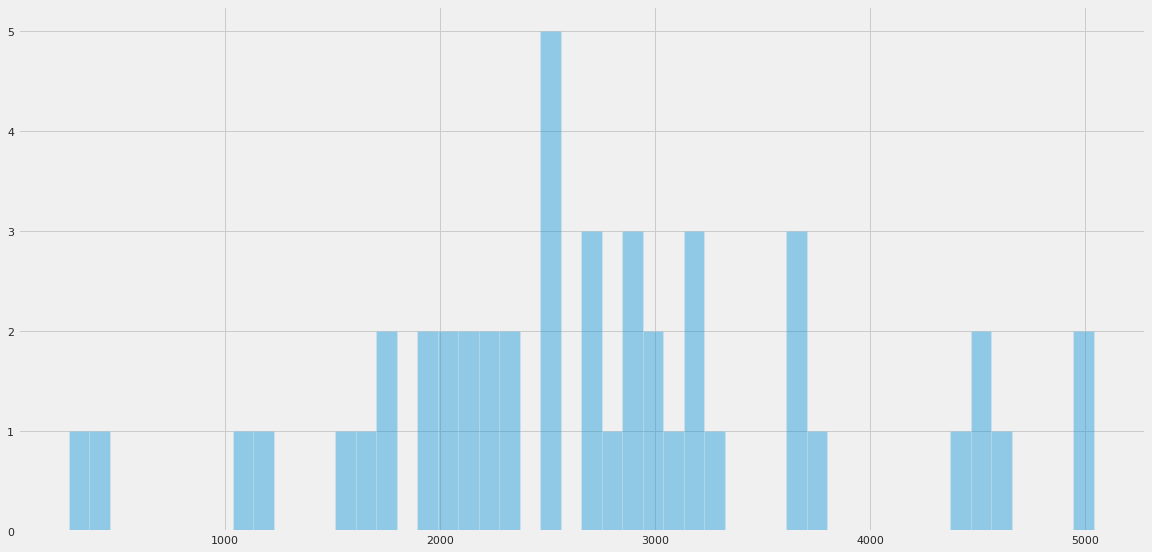

In [64]:
sns.distplot(list(presconf_script_keyword_df['word_count']), bins=50, kde=False)

In [65]:
# Drop text during the process to reduce the output size
presconf_script_chair_day_df.drop(columns=['text_sections', 'org_text'], inplace=True)
presconf_script_split_df.drop(columns=['text_sections', 'org_text'], inplace=True)
presconf_script_keyword_df.drop(columns=['text_sections', 'org_text'], inplace=True)

## Meeting Script DataFrame

In [66]:
meeting_script_df.head()

,date,contents,speaker,title
0,1980-01-09,MR. STERNLIGHT.\r\n\n[SECTION]\n\nCHAIRMAN VOLCKER.\rsecurities] since when?\r\n\n[SECTION]\n\nMR. STERNLIGHT.\r\r[Statement--see Appendix.]\r[That was the change in System holdings of\rThat was f...,other,FOMC Meeting Transcript
1,1980-02-05,CHAIRMAN VOLCKER. I will call the non-meeting to order. We\rare not in a meeting at this point anyway; we may be in a meeting\rlater. I would just remind all of you that I sent out a memorandum on...,other,FOMC Meeting Transcript
2,1980-03-18,"CHAIRMAN VOLCKER. The meeting can come to order, gentlemen\rand lady. We have a lot of business to dispose of at the start and I\rwill try to find my agenda, if you will excuse me a moment. We hav...",other,FOMC Meeting Transcript
3,1980-04-22,"CHAIRMAN VOLCKER.\rCan we come to order, ladies and\rgentlemen?\rI am delighted to say that our Vice Chairman, Mr. Solomon,\rwho was duly elected in absentia last time, is with us today. Welcome\r...",other,FOMC Meeting Transcript
4,1980-05-20,"CHAIRMAN VOLCKER. Let us proceed, ladies and gentlemen.\rneed to approve the minutes.\r\n\n[SECTION]\n\nMR. SCHULTZ.\r\rSo moved.\r\r\n\n[SECTION]\n\nCHAIRMAN VOLCKER.\r\n\n[SECTION]\n\nMS. TEETER...",other,FOMC Meeting Transcript


In [67]:
# Reorganize the dataframe
proc_meeting_script_df = reorganize_df(meeting_script_df, 'meeting_script')

No rate decision found:  282
Shape of the dataframe:  (282, 13)


In [68]:
# Sample
print(meeting_script_df['contents'][2])

--and we need a nomination.

[SECTION]

of the FOMC!

[SECTION]

CHAIRMAN VOLCKER.

[SECTION]

MR. PARTEE.

[SECTION]



[SECTION]

that way!

[SECTION]



[SECTION]

Chairman.

[SECTION]

Vice Chairman of the FOMC.

[SECTION]

date. Is there a second?

[SECTION]



[SECTION]

the nominees.

[SECTION]

That's the list, Mr. Chairman.

[SECTION]

plenitude of Davises--pardon me?

[SECTION]



[SECTION]

motion to that effect?

[SECTION]



[SECTION]

[reappointment them]?

[SECTION]



[SECTION]

have a motion?

[SECTION]



[SECTION]

CHAIRMAN VOLCKER.

[SECTION]



[SECTION]

since the last meeting, Mr. Pardee.

[SECTION]



[SECTION]

price of gold. Would that include any major commercial banks?

[SECTION]

past from the U.S. Treasury.

[SECTION]



[SECTION]

they can withstand such losses.

[SECTION]

dollar to go up in the face of that?

[SECTION]

bearish.

[SECTION]

of that?

[SECTION]

amounts.

[SECTION]

absence of intervention.

[SECTION]

[the dollar] has been pretty steady

In [69]:
# Check the returned dataframe
proc_meeting_script_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,meeting_script,1980-01-09,FOMC Meeting Transcript,other,45039,<NA>,None,1980-02-05,<NA>,None,MR. STERNLIGHT.[SECTION]CHAIRMAN VOLCKER.securities] since when?[SECTION]MR. STERNLIGHT.[Statement--see Appendix.][That was the change in System holdings ofThat was for all of '79.[SECTION]CHAIRMA...,"[MR. STERNLIGHT., CHAIRMAN VOLCKER.securities] since when?, MR. STERNLIGHT.[Statement--see Appendix.][That was the change in System holdings ofThat was for all of '79., CHAIRMAN VOLCKER. Steve, if...",MR. STERNLIGHT.\r\n\n[SECTION]\n\nCHAIRMAN VOLCKER.\rsecurities] since when?\r\n\n[SECTION]\n\nMR. STERNLIGHT.\r\r[Statement--see Appendix.]\r[That was the change in System holdings of\rThat was f...
1,meeting_script,1980-02-05,FOMC Meeting Transcript,other,39604,<NA>,None,1980-02-22,<NA>,None,CHAIRMAN VOLCKER. I will call the non-meeting to order. Weare not in a meeting at this point anyway; we may be in a meetinglater. I would just remind all of you that I sent out a memorandum onthe ...,[CHAIRMAN VOLCKER. I will call the non-meeting to order. Weare not in a meeting at this point anyway; we may be in a meetinglater. I would just remind all of you that I sent out a memorandum onthe...,CHAIRMAN VOLCKER. I will call the non-meeting to order. We\rare not in a meeting at this point anyway; we may be in a meeting\rlater. I would just remind all of you that I sent out a memorandum on...
2,meeting_script,1980-03-18,FOMC Meeting Transcript,other,23954,<NA>,None,1980-04-22,<NA>,None,"CHAIRMAN VOLCKER. The meeting can come to order, gentlemenand lady. We have a lot of business to dispose of at the start and Iwill try to find my agenda, if you will excuse me a moment. We havethe...","[CHAIRMAN VOLCKER. The meeting can come to order, gentlemenand lady. We have a lot of business to dispose of at the start and Iwill try to find my agenda, if you will excuse me a moment. We haveth...","CHAIRMAN VOLCKER. The meeting can come to order, gentlemen\rand lady. We have a lot of business to dispose of at the start and I\rwill try to find my agenda, if you will excuse me a moment. We hav..."
3,meeting_script,1980-04-22,FOMC Meeting Transcript,other,21170,<NA>,None,1980-04-29,<NA>,None,"CHAIRMAN VOLCKER.Can we come to order, ladies andgentlemen?I am delighted to say that our Vice Chairman, Mr. Solomon,who was duly elected in absentia last time, is with us today. Welcometo your fi...","[CHAIRMAN VOLCKER.Can we come to order, ladies andgentlemen?I am delighted to say that our Vice Chairman, Mr. Solomon,who was duly elected in absentia last time, is with us today. Welcometo your f...","CHAIRMAN VOLCKER.\rCan we come to order, ladies and\rgentlemen?\rI am delighted to say that our Vice Chairman, Mr. Solomon,\rwho was duly elected in absentia last time, is with us today. Welcome\r..."
4,meeting_script,1980-05-20,FOMC Meeting Transcript,other,24276,<NA>,None,1980-06-05,<NA>,None,"CHAIRMAN VOLCKER. Let us proceed, ladies and gentlemen.need to approve the minutes.[SECTION]MR. SCHULTZ.So moved.[SECTION]CHAIRMAN VOLCKER.[SECTION]MS. TEETERS.WeDo we have a second?Second.[SECTIO...","[CHAIRMAN VOLCKER. Let us proceed, ladies and gentlemen.need to approve the minutes., MR. SCHULTZ.So moved., CHAIRMAN VOLCKER., MS. TEETERS.WeDo we have a second?Second., CHAIRMAN VOLCKER. Without...","CHAIRMAN VOLCKER. Let us proceed, ladies and gentlemen.\rneed to approve the minutes.\r\n\n[SECTION]\n\nMR. SCHULTZ.\r\rSo moved.\r\r\n\n[SECTION]\n\nCHAIRMAN VOLCKER.\r\n\n[SECTION]\n\nMS. TEETER..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,meeting_script,2014-06-18,FOMC Meeting Transcript,Janet Yellen,88988,<NA>,None,2014-07-30,<NA>,None,"CHAIR YELLEN. I’d like to begin by welcoming three people to the table today: StanFischer, Lael Brainard, and Loretta Mester. This is the first FOMC meeting for both Stan andLael, but both have ve...","[CHAIR YELLEN. I’d like to 

In [70]:
# Check which row does not have rate
proc_meeting_script_df.loc[proc_meeting_script_df['rate'].isnull()]

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,meeting_script,1980-01-09,FOMC Meeting Transcript,other,45039,<NA>,None,1980-02-05,<NA>,None,MR. STERNLIGHT.[SECTION]CHAIRMAN VOLCKER.securities] since when?[SECTION]MR. STERNLIGHT.[Statement--see Appendix.][That was the change in System holdings ofThat was for all of '79.[SECTION]CHAIRMA...,"[MR. STERNLIGHT., CHAIRMAN VOLCKER.securities] since when?, MR. STERNLIGHT.[Statement--see Appendix.][That was the change in System holdings ofThat was for all of '79., CHAIRMAN VOLCKER. Steve, if...",MR. STERNLIGHT.\r\n\n[SECTION]\n\nCHAIRMAN VOLCKER.\rsecurities] since when?\r\n\n[SECTION]\n\nMR. STERNLIGHT.\r\r[Statement--see Appendix.]\r[That was the change in System holdings of\rThat was f...
1,meeting_script,1980-02-05,FOMC Meeting Transcript,other,39604,<NA>,None,1980-02-22,<NA>,None,CHAIRMAN VOLCKER. I will call the non-meeting to order. Weare not in a meeting at this point anyway; we may be in a meetinglater. I would just remind all of you that I sent out a memorandum onthe ...,[CHAIRMAN VOLCKER. I will call the non-meeting to order. Weare not in a meeting at this point anyway; we may be in a meetinglater. I would just remind all of you that I sent out a memorandum onthe...,CHAIRMAN VOLCKER. I will call the non-meeting to order. We\rare not in a meeting at this point anyway; we may be in a meeting\rlater. I would just remind all of you that I sent out a memorandum on...
2,meeting_script,1980-03-18,FOMC Meeting Transcript,other,23954,<NA>,None,1980-04-22,<NA>,None,"CHAIRMAN VOLCKER. The meeting can come to order, gentlemenand lady. We have a lot of business to dispose of at the start and Iwill try to find my agenda, if you will excuse me a moment. We havethe...","[CHAIRMAN VOLCKER. The meeting can come to order, gentlemenand lady. We have a lot of business to dispose of at the start and Iwill try to find my agenda, if you will excuse me a moment. We haveth...","CHAIRMAN VOLCKER. The meeting can come to order, gentlemen\rand lady. We have a lot of business to dispose of at the start and I\rwill try to find my agenda, if you will excuse me a moment. We hav..."
3,meeting_script,1980-04-22,FOMC Meeting Transcript,other,21170,<NA>,None,1980-04-29,<NA>,None,"CHAIRMAN VOLCKER.Can we come to order, ladies andgentlemen?I am delighted to say that our Vice Chairman, Mr. Solomon,who was duly elected in absentia last time, is with us today. Welcometo your fi...","[CHAIRMAN VOLCKER.Can we come to order, ladies andgentlemen?I am delighted to say that our Vice Chairman, Mr. Solomon,who was duly elected in absentia last time, is with us today. Welcometo your f...","CHAIRMAN VOLCKER.\rCan we come to order, ladies and\rgentlemen?\rI am delighted to say that our Vice Chairman, Mr. Solomon,\rwho was duly elected in absentia last time, is with us today. Welcome\r..."
4,meeting_script,1980-05-20,FOMC Meeting Transcript,other,24276,<NA>,None,1980-06-05,<NA>,None,"CHAIRMAN VOLCKER. Let us proceed, ladies and gentlemen.need to approve the minutes.[SECTION]MR. SCHULTZ.So moved.[SECTION]CHAIRMAN VOLCKER.[SECTION]MS. TEETERS.WeDo we have a second?Second.[SECTIO...","[CHAIRMAN VOLCKER. Let us proceed, ladies and gentlemen.need to approve the minutes., MR. SCHULTZ.So moved., CHAIRMAN VOLCKER., MS. TEETERS.WeDo we have a second?Second., CHAIRMAN VOLCKER. Without...","CHAIRMAN VOLCKER. Let us proceed, ladies and gentlemen.\rneed to approve the minutes.\r\n\n[SECTION]\n\nMR. SCHULTZ.\r\rSo moved.\r\r\n\n[SECTION]\n\nCHAIRMAN VOLCKER.\r\n\n[SECTION]\n\nMS. TEETER..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,meeting_script,2014-06-18,FOMC Meeting Transcript,Janet Yellen,88988,<NA>,None,2014-07-30,<NA>,None,"CHAIR YELLEN. I’d like to begin by welcoming three people to the table today: StanFischer, Lael Brainard, and Loretta Mester. This is the first FOMC meeting for both Stan andLael, but both have ve...","[CHAIR YELLEN. I’d like to 

(282, 13)


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


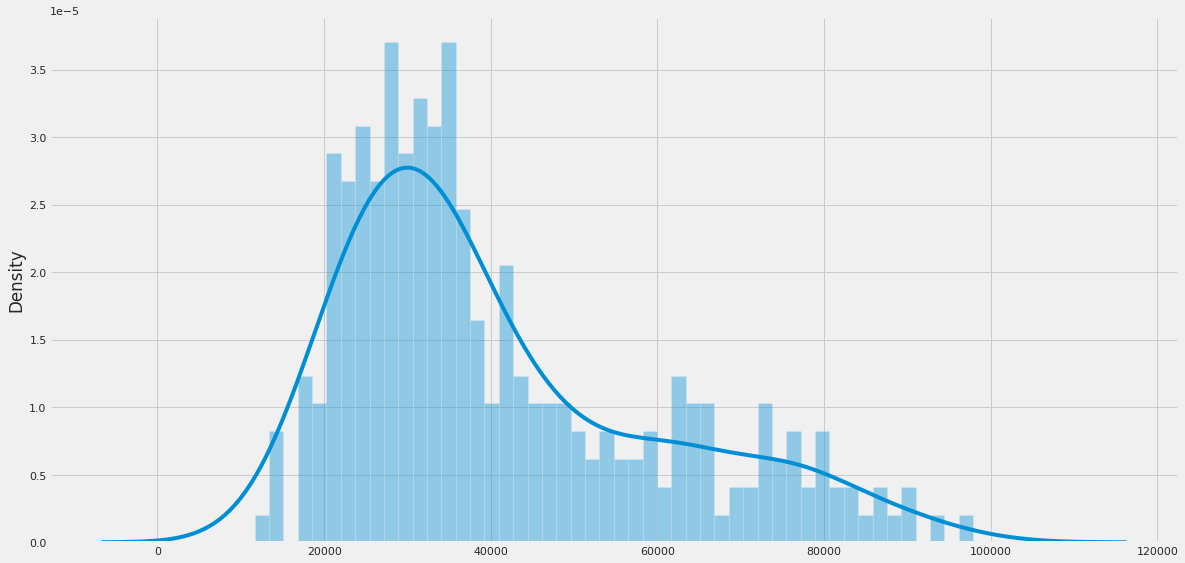

In [71]:
print(proc_meeting_script_df.shape)
sns.distplot(proc_meeting_script_df["word_count"].values, bins=50)

### Split by speakers
Scripts contain words from different people, so split by the speaker

In [72]:
script_data_list = []

for i, row in tqdm(proc_meeting_script_df.iterrows()):
    for text in row["text_sections"]:
        match = re.findall(r'(^[A-Za-zŞ. ]*[A-Z]{3}).\d? (.*)', text)
        if len(match) == 0:
            match = re.findall(r'(^[A-Za-zŞ. ]*[A-Z]{3}).\d(.*)', text)
            if len(match) == 0:
                print("not matched: ", text)
                print(row['date'])
                print()
        if len(match) == 1:
            speaker, text = match[0]
            row['speaker'] = speaker
            row['text'] = text
            row['word_count'] = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text))
            script_data_list.append(list(row))

col_name = proc_meeting_script_df.columns

meeting_script_speaker_df = pd.DataFrame(script_data_list, columns = col_name)
meeting_script_speaker_df

Streaming output truncated to the last 5000 lines.

not matched:  MR. HOENIG.Thank you.
1994-07-06 00:00:00

not matched:  MR. LINDSEY.The inflation blip but not the nominal GDPblip?
1994-07-06 00:00:00

not matched:  MR. KOHN.I call on Mr. Kohn.[Statement--See Appendix.]
1994-07-06 00:00:00

not matched:  MR. KOHN.I think the models embody a vertical long-runPhillips curve; it takes a while for it to come out here.
1994-07-06 00:00:00

not matched:  MR. LINDSEY.Into the next millennium!If you had not noticed that the inflation
1994-07-06 00:00:00

not matched:  MR. KOHN.But never backwards?No.Only the coefficient is unchanged even
1994-07-06 00:00:00

not matched:  MR. KOHN.stretched out--In this time period, that's right.
1994-07-06 00:00:00

not matched:  MR. LINDSEY.No, go ahead, please finish.
1994-07-06 00:00:00

not matched:  MR. LINDSEY.Right.
1994-07-06 00:00:00

not matched:  MR. LINDSEY.And when will we ever pay the price?
1994-07-06 00:00:00

not matched:  MR. LINDSEY.But t

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,meeting_script,1980-01-09,FOMC Meeting Transcript,CHAIRMA,4,<NA>,None,1980-02-05,<NA>,None,VOLCKER.securities] since when?,"[MR. STERNLIGHT., CHAIRMAN VOLCKER.securities] since when?, MR. STERNLIGHT.[Statement--see Appendix.][That was the change in System holdings ofThat was for all of '79., CHAIRMAN VOLCKER. Steve, if...",MR. STERNLIGHT.\r\n\n[SECTION]\n\nCHAIRMAN VOLCKER.\rsecurities] since when?\r\n\n[SECTION]\n\nMR. STERNLIGHT.\r\r[Statement--see Appendix.]\r[That was the change in System holdings of\rThat was f...
1,meeting_script,1980-01-09,FOMC Meeting Transcript,CHAIRMAN VOLCKER,25,<NA>,None,1980-02-05,<NA>,None,"Steve, if you want to add something thatbears upon the nature of the operations, this is probably as good atime as any to do it.","[MR. STERNLIGHT., CHAIRMAN VOLCKER.securities] since when?, MR. STERNLIGHT.[Statement--see Appendix.][That was the change in System holdings ofThat was for all of '79., CHAIRMAN VOLCKER. Steve, if...",MR. STERNLIGHT.\r\n\n[SECTION]\n\nCHAIRMAN VOLCKER.\rsecurities] since when?\r\n\n[SECTION]\n\nMR. STERNLIGHT.\r\r[Statement--see Appendix.]\r[That was the change in System holdings of\rThat was f...
2,meeting_script,1980-01-09,FOMC Meeting Transcript,MR. AXILROD,1205,<NA>,None,1980-02-05,<NA>,None,"Mr. Chairman, we have some tables we could passout, which are somewhat similar to the ones that we made available tothe Committee at the last meeting and which might be helpful inconsidering how a...","[MR. STERNLIGHT., CHAIRMAN VOLCKER.securities] since when?, MR. STERNLIGHT.[Statement--see Appendix.][That was the change in System holdings ofThat was for all of '79., CHAIRMAN VOLCKER. Steve, if...",MR. STERNLIGHT.\r\n\n[SECTION]\n\nCHAIRMAN VOLCKER.\rsecurities] since when?\r\n\n[SECTION]\n\nMR. STERNLIGHT.\r\r[Statement--see Appendix.]\r[That was the change in System holdings of\rThat was f...
3,meeting_script,1980-01-09,FOMC Meeting Transcript,CHAIRMAN VOLCKER,31,<NA>,None,1980-02-05,<NA>,None,"I'm sure that's crystal clear!So, Ithink it's time to raise questions--not just on the details of Peter'soperations, but questions that bear upon the operating techniquesgenerally. Governor Partee.","[MR. STERNLIGHT., CHAIRMAN VOLCKER.securities] since when?, MR. STERNLIGHT.[Statement--see Appendix.][That was the change in System holdings ofThat was for all of '79., CHAIRMAN VOLCKER. Steve, if...",MR. STERNLIGHT.\r\n\n[SECTION]\n\nCHAIRMAN VOLCKER.\rsecurities] since when?\r\n\n[SECTION]\n\nMR. STERNLIGHT.\r\r[Statement--see Appendix.]\r[That was the change in System holdings of\rThat was f...
4,meeting_script,1980-01-09,FOMC Meeting Transcript,MR. PARTEE,107,<NA>,None,1980-02-05,<NA>,None,"Well, just a comment. I think I understood thedirection of your adjustments, Steve, as you went through this. But Icertainly don't understand it from this table on the second page. Ican't make out...","[MR. STERNLIGHT., CHAIRMAN VOLCKER.securities] since when?, MR. STERNLIGHT.[Statement--see Appendix.][That was the change in System holdings ofThat was for all of '79., CHAIRMAN VOLCKER. Steve, if...",MR. STERNLIGHT.\r\n\n[SECTION]\n\nCHAIRMAN VOLCKER.\rsecurities] since when?\r\n\n[SECTION]\n\nMR. STERNLIGHT.\r\r[Statement--see Appendix.]\r[That was the change in System holdings of\rThat was f...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
88214,meeting_script,2014-12-17,FOMC Meeting Transcript,CHAIR YELLEN,79,<NA>,None,2015-01-28,<NA>,None,"Thank you. Okay. I think the main open issue in the statement is thebracketed word “somewhat” in paragraph 1, and I heard one, two, three, four, five, six—eightpeople propose removing it. I’m cert...","[CHAIR YELLEN. Good afternoon, everyone. I think we are ready to begin. The firstitem we are going to consider is in a joint Board and FOMC meeting, so I need a motion to closethe Board meeting., ...","CHAIR YELLEN. Good afternoon, everyone. I think

Some are not matching the defined patterns but those unmatched ones do not look importnant. Thus ignore them here.

In [73]:
# Filter by word count having 20 or more.
print("Before: ", meeting_script_speaker_df.shape)
meeting_script_speaker_df = meeting_script_speaker_df.loc[meeting_script_speaker_df['word_count'] >= 20]
print("After: ", meeting_script_speaker_df.shape)

Before:  (88219, 13)
After:  (47498, 13)


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


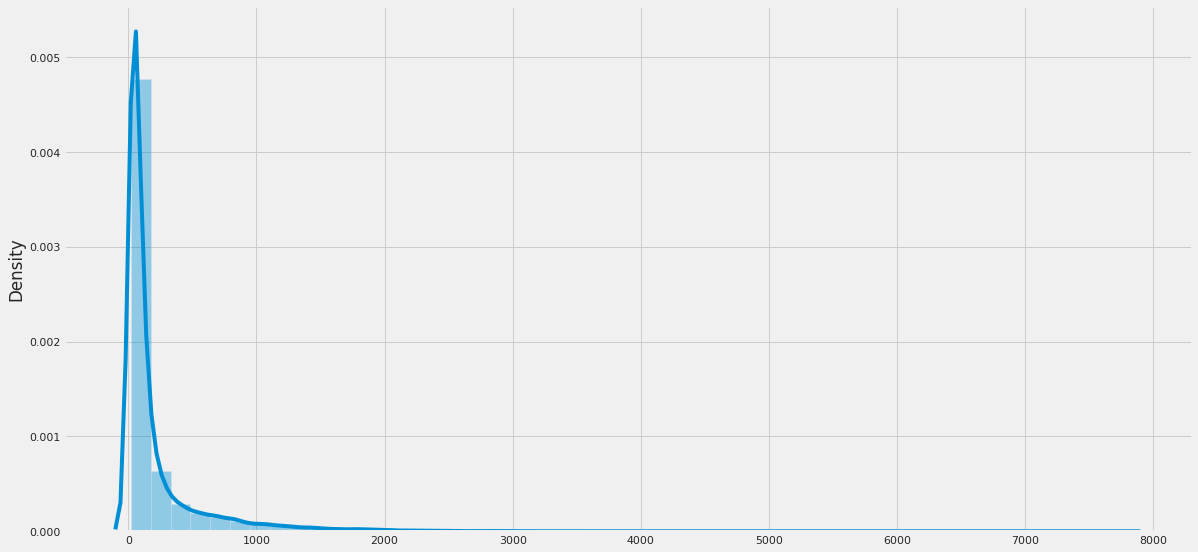

In [74]:
sns.distplot(meeting_script_speaker_df["word_count"].values, bins=50)

In [75]:
# Combine scripts for the same day.
meeting_script_speaker_df = meeting_script_speaker_df['text'].apply('[SECTION]'.join).reset_index()
meeting_script_speaker_df['text_sections'] = meeting_script_speaker_df['text'].map(lambda x: x.split("[SECTION]"))
meeting_script_speaker_df['text'] = meeting_script_speaker_df['text'].map(lambda x: x.replace("[SECTION]", ""))
meeting_script_speaker_df['word_count'] = meeting_script_speaker_df['text'].map(get_word_count)
meeting_script_speaker_df

,index,text,text_sections,word_count
0,1,"Steve, if you want to add something thatbears upon the nature of the operations, this is probably as good atime as any to do it.","[S, t, e, v, e, ,, , i, f, , y, o, u, , w, a, n, t, , t, o, , a, d, d, , s, o, m, e, t, h, i, n, g, , t, h, a, t, b, e, a, r, s, , u, p, o, n, ...]",25
1,2,"Mr. Chairman, we have some tables we could passout, which are somewhat similar to the ones that we made available tothe Committee at the last meeting and which might be helpful inconsidering how a...","[M, r, ., , C, h, a, i, r, m, a, n, ,, , w, e, , h, a, v, e, , s, o, m, e, , t, a, b, l, e, s, , w, e, , c, o, u, l, d, , p, a, s, s, o, u, t, ...]",1205
2,3,"I'm sure that's crystal clear!So, Ithink it's time to raise questions--not just on the details of Peter'soperations, but questions that bear upon the operating techniquesgenerally. Governor Partee.","[I, ', m, , s, u, r, e, , t, h, a, t, ', s, , c, r, y, s, t, a, l, , c, l, e, a, r, !, S, o, ,, , I, t, h, i, n, k, , i, t, ', s, , t, i, m, e, ...]",31
3,4,"Well, just a comment. I think I understood thedirection of your adjustments, Steve, as you went through this. But Icertainly don't understand it from this table on the second page. Ican't make out...","[W, e, l, l, ,, , j, u, s, t, , a, , c, o, m, m, e, n, t, ., , I, , t, h, i, n, k, , I, , u, n, d, e, r, s, t, o, o, d, , t, h, e, d, i, r, e, ...]",107
4,6,"Well, one of the things that is disturbing me-about the whole period really but particularly the last month or so-is that we don't seem to be getting any market impact. We have tohave feed-through...","[W, e, l, l, ,, , o, n, e, , o, f, , t, h, e, , t, h, i, n, g, s, , t, h, a, t, , i, s, , d, i, s, t, u, r, b, i, n, g, , m, e, -, a, b, o, u, ...]",131
...,...,...,...,...
47493,88209,"Thank you. Since we last met, we have seen two strong payrollreports, and the labor market is clearly continuing to strengthen, which is very welcome. But, ofcourse, we also see continued risks as...","[T, h, a, n, k, , y, o, u, ., , S, i, n, c, e, , w, e, , l, a, s, t, , m, e, t, ,, , w, e, , h, a, v, e, , s, e, e, n, , t, w, o, , s, t, r, ...]",480
47494,88213,"No worries. It happened one time under ChairmanBernanke’s watch, too. So you can do it once. [Laughter.] I support alternative B, and I am December 16–17, 2014170 of 219comfortable with what the C...","[N, o, , w, o, r, r, i, e, s, ., , I, t, , h, a, p, p, e, n, e, d, , o, n, e, , t, i, m, e, , u, n, d, e, r, , C, h, a, i, r, m, a, n, B, e, r, ...]",1412
47495,88214,"Thank you. Okay. I think the main open issue in the statement is thebracketed word “somewhat” in paragraph 1, and I heard one, two, three, four, five, six—eightpeople propose removing it. I’m cert...","[T, h, a, n, k, , y, o, u, ., , O, k, a, y, ., , I, , t, h, i, n, k, , t, h, e, , m, a, i, n, , o, p, e, n, , i, s, s, u, e, , i, n, , t, h, ...]",79
47496,88215,"This vote, as Chair Yellen indicated, will be on alternative B, depictedon pages 6 and 7 of Bill English’s handout. It will not have the word “somewhat” on line 3. Itwill also cover the directive ...","[T, h, i, s, , v, o, t, e, ,, , a, s, , C, h, a, i, r, , Y, e, l, l, e, n, , i, n, d, i, c, a, t, e, d, ,, , w, i, l, l, , b, e, , o, n, , a, ...]",47


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


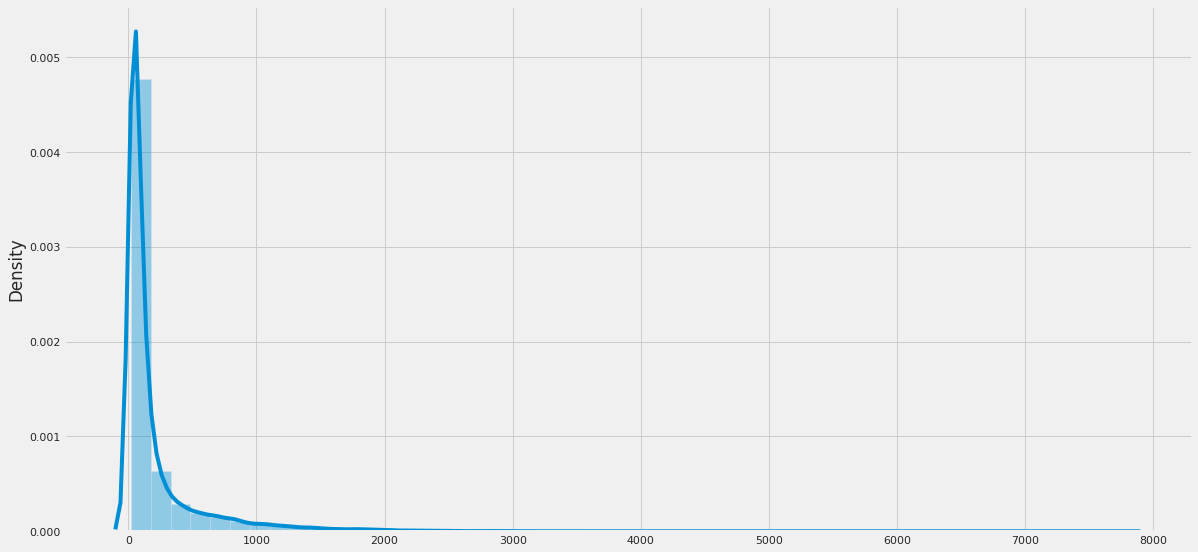

In [76]:
sns.distplot(meeting_script_speaker_df["word_count"].values, bins=50)

### Split contents to max 200 words

In [77]:
meeting_script_split_df = get_split_df(meeting_script_speaker_df)
print(meeting_script_split_df.shape)
meeting_script_split_df


       index  ... word_count
0          1  ...         25
1          2  ...        200
2          2  ...        200
3          2  ...        200
4          2  ...        200
...      ...  ...        ...
87669  88213  ...        200
87670  88213  ...         62
87671  88214  ...         79
87672  88215  ...         47
87673  88216  ...         71

[87674 rows x 4 columns]
(87674, 4)


,index,text,text_sections,word_count
0,1,Steve if you want to add something thatbears upon the nature of the operations this is probably as good atime as any to do it,"[S, t, e, v, e, ,, , i, f, , y, o, u, , w, a, n, t, , t, o, , a, d, d, , s, o, m, e, t, h, i, n, g, , t, h, a, t, b, e, a, r, s, , u, p, o, n, ...]",25
1,2,Mr Chairman we have some tables we could passout which are somewhat similar to the ones that we made available tothe Committee at the last meeting and which might be helpful inconsidering how and ...,"[M, r, ., , C, h, a, i, r, m, a, n, ,, , w, e, , h, a, v, e, , s, o, m, e, , t, a, b, l, e, s, , w, e, , c, o, u, l, d, , p, a, s, s, o, u, t, ...]",200
2,2,in the November to December period of something like In the event as you saw in the Bluebook we were a bitshort on the growth rate in and also in but I think within anyreasonable margin of error w...,"[M, r, ., , C, h, a, i, r, m, a, n, ,, , w, e, , h, a, v, e, , s, o, m, e, , t, a, b, l, e, s, , w, e, , c, o, u, l, d, , p, a, s, s, o, u, t, ...]",200
3,2,a decline in the original totalreserve path So that is the added adjustment to nonborrowed reservesbecause total reserves were running short of what seemed consistentwith this money stock figure a...,"[M, r, ., , C, h, a, i, r, m, a, n, ,, , w, e, , h, a, v, e, , s, o, m, e, , t, a, b, l, e, s, , w, e, , c, o, u, l, d, , p, a, s, s, o, u, t, ...]",200
4,2,That's justsimply arithmetic The source of some of the problems we were having is shown onthe next page they are inherent in this kind of targeting procedure Again I d say that thus far I think we...,"[M, r, ., , C, h, a, i, r, m, a, n, ,, , w, e, , h, a, v, e, , s, o, m, e, , t, a, b, l, e, s, , w, e, , c, o, u, l, d, , p, a, s, s, o, u, t, ...]",200
...,...,...,...,...
87669,88213,is expected to move back toward target We could even be a little bitmore positive on the growth side in paragraph but I can accept it as written I would take outthe word somewhat because I do thin...,"[N, o, , w, o, r, r, i, e, s, ., , I, t, , h, a, p, p, e, n, e, d, , o, n, e, , t, i, m, e, , u, n, d, e, r, , C, h, a, i, r, m, a, n, B, e, r, ...]",200
87670,88213,ofcourse you want to begin this process well before employment and inflation reach your December of I believe many market participants are confused about this and that explains some ofthe differen...,"[N, o, , w, o, r, r, i, e, s, ., , I, t, , h, a, p, p, e, n, e, d, , o, n, e, , t, i, m, e, , u, n, d, e, r, , C, h, a, i, r, m, a, n, B, e, r, ...]",62
87671,88214,Thank you Okay I think the main open issue in the statement is thebracketed word somewhat in paragraph and I heard one two three four five six eightpeople propose removing it I m certainly comfort...,"[T, h, a, n, k, , y, o, u, ., , O, k, a, y, ., , I, , t, h, i, n, k, , t, h, e, , m, a, i, n, , o, p, e, n, , i, s, s, u, e, , i, n, , t, h, ...]",79
87672,88215,This vote as Chair Yellen indicated will be on alternative B depictedon pages and of Bill English s handout It will not have the word somewhat on line Itwill also cover the directive on page Chair...,"[T, h, i, s, , v, o, t, e, ,, , a, s, , C, h, a, i, r, , Y, e, l, l, e, n, , i, n, d, i, c, a, t, e, d, ,, , w, i, l, l, , b, e, , o, n, , a, ...]",47


### Filter out by keywords

In [78]:
# Keep sections having keywords and long enough
meeting_script_keyword_df = remove_short_nokeyword(meeting_script_speaker_df)
meeting_script_keyword_df.reset_index(drop=False, inplace=True)
print(meeting_script_keyword_df.shape)
meeting_script_keyword_df


(0, 5)


,level_0,index,text,text_sections,word_count


In [79]:
# Drop text during the process to reduce the output size
meeting_script_speaker_df.drop(columns=['text_sections'], inplace=True)
meeting_script_split_df.drop(columns=['text_sections'], inplace=True)
meeting_script_keyword_df.drop(columns=['text_sections'], inplace=True)

## Speech DataFrame

In [80]:
# Reorganize the dataframe
proc_speech_df = reorganize_df(speech_df, 'speech')

No rate decision found:  1490
Shape of the dataframe:  (1490, 13)


In [81]:
# Check the returned dataframe
# Note that rate and decision are not applicable because speech is not at FOMC meeting
proc_speech_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,speech,1996-06-13,Bank supervision in a world economy,Chairman Alan Greenspan,3211,<NA>,None,1996-07-03,<NA>,None,"Remarks by Chairman Alan GreenspanBank supervision in a world economyAt the International Conference of Banking Supervisors, Stockholm, SwedenJune 13, 1996[SECTION][SECTION]I am honored to present...","[Remarks by Chairman Alan GreenspanBank supervision in a world economyAt the International Conference of Banking Supervisors, Stockholm, SwedenJune 13, 1996, , I am honored to present the William ...","Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n[SECTION]\n\n\n\n[SECTION]\..."
1,speech,1996-06-18,Developments in electronic money and banking,"Governor Edward W. Kelley, Jr.",2694,<NA>,None,1996-07-03,<NA>,None,"Remarks by Governor Edward W. Kelley, Jr.Developments in electronic money and bankingAt the CyberPayments '96 Conference, Dallas, TexasJune 18, 1996[SECTION][SECTION]It is a pleasure to be here th...","[Remarks by Governor Edward W. Kelley, Jr.Developments in electronic money and bankingAt the CyberPayments '96 Conference, Dallas, TexasJune 18, 1996, , It is a pleasure to be here this afternoon ...","Remarks by Governor Edward W. Kelley, Jr.\nDevelopments in electronic money and banking\r\nAt the CyberPayments '96 Conference, Dallas, Texas\r\nJune 18, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nIt i..."
2,speech,1996-09-08,Monetary policy objectives and strategy,Governor Laurence H. Meyer,2902,<NA>,None,1996-09-24,<NA>,None,Monetary Policy Objectives and Strategy[SECTION]I want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment. But I also want ...,"[Monetary Policy Objectives and Strategy, I want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment. But I also want to emp...",Monetary Policy Objectives and Strategy\n\n[SECTION]\n\nI want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment. But I al...
3,speech,1996-09-19,Regulation and electronic payment systems,Chairman Alan Greenspan,1988,<NA>,None,1996-09-24,<NA>,None,"Remarks by Chairman Alan GreenspanRegulation of electronic payment systemsAt the U.S. Treasury Conference on Electronic Money & Banking: The Role of Government, Washington DC September 19, 1996[SE...","[Remarks by Chairman Alan GreenspanRegulation of electronic payment systemsAt the U.S. Treasury Conference on Electronic Money & Banking: The Role of Government, Washington DC September 19, 1996, ...","Remarks by Chairman Alan Greenspan\nRegulation of electronic payment systems\r\nAt the U.S. Treasury Conference on Electronic Money & Banking: The Role of Government, Washington DC \r\nSeptember 1..."
4,speech,1996-10-02,Small business is big business,Governor Lawrence B. Lindsey,2180,<NA>,None,1996-11-13,<NA>,None,"Remarks by Governor Lawrence B. LindseyAt the Small Business Development Conference, Richmond, VirginiaOctober 2, 1996[SECTION][SECTION]Small Business Is Big Business[SECTION]It is my pleasure to ...","[Remarks by Governor Lawrence B. LindseyAt the Small Business Development Conference, Richmond, VirginiaOctober 2, 1996, , Small Business Is Big Business, It is my pleasure to be here today at the...","Remarks by Governor Lawrence B. Lindsey\r\nAt the Small Business Development Conference, Richmond, Virginia\r\nOctober 2, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nSmall Business Is Big Business\n\n[S..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1485,speech,2020-10-20,Modernizing and Strengthening CRA Regulations: A Conversation with the Housing Community,Governor Lael Brainard,2210,<NA>,None,2020-11-05,<NA>,None,"The Federal Reserve, th

(1490, 13)


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


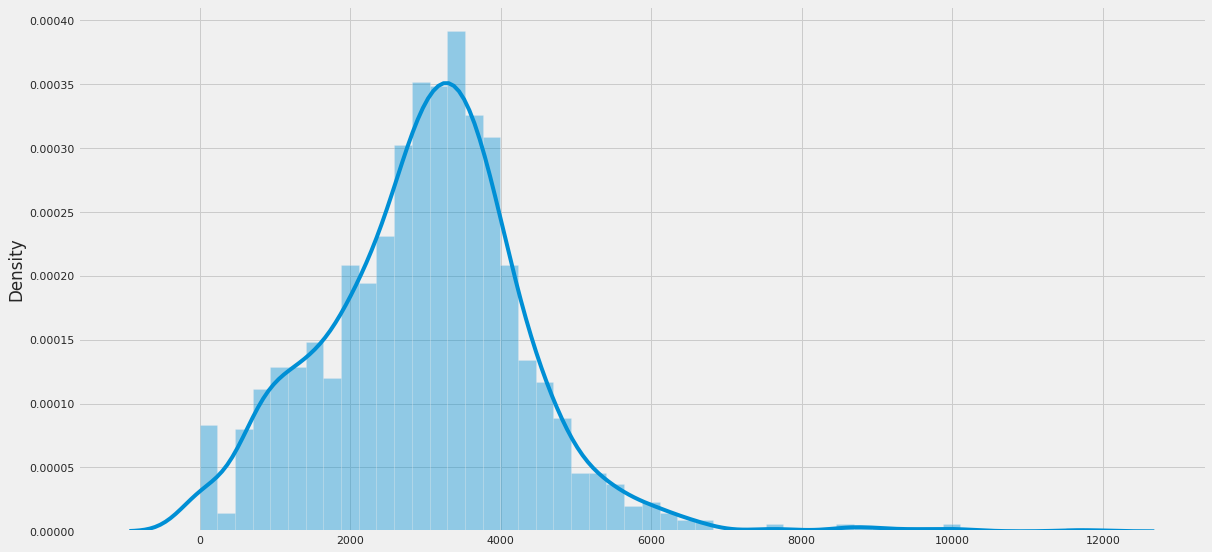

In [82]:
print(proc_speech_df.shape)
sns.distplot(proc_speech_df["word_count"].values, bins=50)

In [83]:
# Check records where speaker is null
proc_speech_df['speaker'].isnull().sum()

0

In [84]:
# Remove sections having less than 50 words because those are unlikely to contain meaningful sentences.
proc_speech_df = remove_short_section(proc_speech_df, min_words=50)
proc_speech_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,speech,1996-06-13,Bank supervision in a world economy,Chairman Alan Greenspan,3095,<NA>,None,1996-07-03,<NA>,None,I am honored to present the William Taylor Memorial Lecture to such a distinguished group of senior bank supervisors from around the world. I am especially delighted to have with us B...,"[Remarks by Chairman Alan GreenspanBank supervision in a world economyAt the International Conference of Banking Supervisors, Stockholm, SwedenJune 13, 1996, , I am honored to present the William ...","Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n[SECTION]\n\n\n\n[SECTION]\..."
1,speech,1996-06-18,Developments in electronic money and banking,"Governor Edward W. Kelley, Jr.",2659,<NA>,None,1996-07-03,<NA>,None,"It is a pleasure to be here this afternoon to provide the Federal Reserve's perspective on recent developments in the field of electronic money and banking. To begin, let me remind yo...","[Remarks by Governor Edward W. Kelley, Jr.Developments in electronic money and bankingAt the CyberPayments '96 Conference, Dallas, TexasJune 18, 1996, , It is a pleasure to be here this afternoon ...","Remarks by Governor Edward W. Kelley, Jr.\nDevelopments in electronic money and banking\r\nAt the CyberPayments '96 Conference, Dallas, Texas\r\nJune 18, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nIt i..."
2,speech,1996-09-08,Monetary policy objectives and strategy,Governor Laurence H. Meyer,2729,<NA>,None,1996-09-24,<NA>,None,I want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment. But I also want to emphasize the importance of setting monetary ...,"[Monetary Policy Objectives and Strategy, I want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment. But I also want to emp...",Monetary Policy Objectives and Strategy\n\n[SECTION]\n\nI want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment. But I al...
3,speech,1996-09-19,Regulation and electronic payment systems,Chairman Alan Greenspan,1586,<NA>,None,1996-09-24,<NA>,None,You have heard many points of view today on electronic moneyand banking. New products are being designed to challenge theuse of currency and checks in millions of routine consumertransactions. O...,"[Remarks by Chairman Alan GreenspanRegulation of electronic payment systemsAt the U.S. Treasury Conference on Electronic Money & Banking: The Role of Government, Washington DC September 19, 1996, ...","Remarks by Chairman Alan Greenspan\nRegulation of electronic payment systems\r\nAt the U.S. Treasury Conference on Electronic Money & Banking: The Role of Government, Washington DC \r\nSeptember 1..."
4,speech,1996-10-02,Small business is big business,Governor Lawrence B. Lindsey,2002,<NA>,None,1996-11-13,<NA>,None,"A fair question might be, what is the nation's central bank doing sponsoring aconference on small business? Well, let me be clear about one thing, neither I nor mycolleagues from the Fed are goi...","[Remarks by Governor Lawrence B. LindseyAt the Small Business Development Conference, Richmond, VirginiaOctober 2, 1996, , Small Business Is Big Business, It is my pleasure to be here today at the...","Remarks by Governor Lawrence B. Lindsey\r\nAt the Small Business Development Conference, Richmond, Virginia\r\nOctober 2, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nSmall Business Is Big Business\n\n[S..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1485,speech,2020-10-20,Modernizing and Strengthening CRA Regulations: A Conversation with the Housing Community,Governor Lael Brainard,2005,<NA>,None,2020-11-05,<NA>,None,I want to thank David Dworkin for inviting me to participa

In [85]:
# Extract Chairperson's speech
tmp_list = []
for i, row in proc_speech_df.iterrows():
    chairperson = get_chairperson(row['date'])
    if chairperson.lower().split()[-1] in row['speaker'].lower():
        row['speaker'] = chairperson
        tmp_list.append(list(row))

col_names = proc_speech_df.columns
speech_chair_df = pd.DataFrame(data=tmp_list, columns=col_names)

print(speech_chair_df.shape)
speech_chair_df

(430, 13)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,speech,1996-06-13,Bank supervision in a world economy,Alan Greenspan,3095,<NA>,None,1996-07-03,<NA>,None,I am honored to present the William Taylor Memorial Lecture to such a distinguished group of senior bank supervisors from around the world. I am especially delighted to have with us B...,"[Remarks by Chairman Alan GreenspanBank supervision in a world economyAt the International Conference of Banking Supervisors, Stockholm, SwedenJune 13, 1996, , I am honored to present the William ...","Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n[SECTION]\n\n\n\n[SECTION]\..."
1,speech,1996-09-19,Regulation and electronic payment systems,Alan Greenspan,1586,<NA>,None,1996-09-24,<NA>,None,You have heard many points of view today on electronic moneyand banking. New products are being designed to challenge theuse of currency and checks in millions of routine consumertransactions. O...,"[Remarks by Chairman Alan GreenspanRegulation of electronic payment systemsAt the U.S. Treasury Conference on Electronic Money & Banking: The Role of Government, Washington DC September 19, 1996, ...","Remarks by Chairman Alan Greenspan\nRegulation of electronic payment systems\r\nAt the U.S. Treasury Conference on Electronic Money & Banking: The Role of Government, Washington DC \r\nSeptember 1..."
2,speech,1996-10-05,"Bank supervision, regulation, and risk",Alan Greenspan,2183,<NA>,None,1996-11-13,<NA>,None,You may well wonder why a regulator is the first speaker at a conference in which amajor theme is maximizing shareholder value. I hope that by the end of my remarks thismorning it will be clear t...,"[Remarks by Chairman Alan GreenspanBank supervision, regulation, and riskAt the Annual Convention of the American Bankers Association, Honolulu, Hawaii October 5, 1996, , You may well wonder why a...","Remarks by Chairman Alan Greenspan\nBank supervision, regulation, and risk\r\nAt the Annual Convention of the American Bankers Association, Honolulu, Hawaii \r\nOctober 5, 1996\n\n[SECTION]\n\n\n\..."
3,speech,1996-10-07,U.S. Treasury securities market: Lessons from Alexander Hamilton,Alan Greenspan,985,<NA>,None,1996-11-13,<NA>,None,I thank the members of the Public Securities Association for bestowing upon me this award for distinguished public service. I am particularly honored by the company that I keep as a winner of thi...,"[Remarks by Chairman Alan GreenspanU.S. Treasury securities market: Lessons from Alexander HamiltonAt the Annual Public Service Awards Dinner of the Public Securities Association, New York, New Yo...","Remarks by Chairman Alan Greenspan\nU.S. Treasury securities market: Lessons from Alexander Hamilton\r\nAt the Annual Public Service Awards Dinner of the Public Securities Association, New York, N..."
4,speech,1996-10-16,Technological advances and productivity,Alan Greenspan,1615,<NA>,None,1996-11-13,<NA>,None,The Conference Board has been an important institution in my life. It was where I started as an economist. It was where I came into contact with a business world I had never known before. The y...,"[Remarks by Chairman Alan GreenspanTechnological advances and productivityAt the 80th Anniversary Awards Dinner of The Conference Board, New York, New YorkOctober 16, 1996, , It is a pleasure to b...","Remarks by Chairman Alan Greenspan\nTechnological advances and productivity\r\nAt the 80th Anniversary Awards Dinner of The Conference Board, New York, New York\r\nOctober 16, 1996\n\n[SECTION]\n\..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
425,speech,2020-05-13,Current Economic Issues,Jerome Powell,1206,<NA>,None,2020-06-10,<NA>,None,"The coronavirus has left a devastating human and economic toll in its wake as it has spread around the globe. This is a worldwide public health crisis, an

### Split contents to max 200 words

In [86]:
speech_split_df = get_split_df(speech_chair_df)
speech_split_df.reset_index(drop=True, inplace=True)
print(speech_split_df.shape)
speech_split_df


        type  ...                                                                                                                                                                                                 org_text
0     speech  ...  Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n[SECTION]\n\n\n\n[SECTION]\...
1     speech  ...  Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n[SECTION]\n\n\n\n[SECTION]\...
2     speech  ...  Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n[SECTION]\n\n\n\n[SECTION]\...
3     speech  ...  Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conferen

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,speech,1996-06-13,Bank supervision in a world economy,Alan Greenspan,200,<NA>,None,1996-07-03,<NA>,None,I am honored to present the William Taylor Memorial Lecture to such a distinguished group of senior bank supervisors from around the world I am especially delighted to have with us Bill's wife Sha...,"[Remarks by Chairman Alan GreenspanBank supervision in a world economyAt the International Conference of Banking Supervisors, Stockholm, SwedenJune 13, 1996, , I am honored to present the William ...","Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n[SECTION]\n\n\n\n[SECTION]\..."
1,speech,1996-06-13,Bank supervision in a world economy,Alan Greenspan,200,<NA>,None,1996-07-03,<NA>,None,best from himself and from those around him He understood that a safe and sound banking system was essential to a healthy market system and he was committed to maintaining such a system His contri...,"[Remarks by Chairman Alan GreenspanBank supervision in a world economyAt the International Conference of Banking Supervisors, Stockholm, SwedenJune 13, 1996, , I am honored to present the William ...","Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n[SECTION]\n\n\n\n[SECTION]\..."
2,speech,1996-06-13,Bank supervision in a world economy,Alan Greenspan,200,<NA>,None,1996-07-03,<NA>,None,reflect the increased efficiency of financial markets worldwide which have helped to bring about expanded international trade and economic growth However by strengthening the interdependencies amo...,"[Remarks by Chairman Alan GreenspanBank supervision in a world economyAt the International Conference of Banking Supervisors, Stockholm, SwedenJune 13, 1996, , I am honored to present the William ...","Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n[SECTION]\n\n\n\n[SECTION]\..."
3,speech,1996-06-13,Bank supervision in a world economy,Alan Greenspan,200,<NA>,None,1996-07-03,<NA>,None,relationship we may have a better framework for considering how to supervise and regulate our financial institutions A Leveraged Banking System In addressing these issues it is important to rememb...,"[Remarks by Chairman Alan GreenspanBank supervision in a world economyAt the International Conference of Banking Supervisors, Stockholm, SwedenJune 13, 1996, , I am honored to present the William ...","Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n[SECTION]\n\n\n\n[SECTION]\..."
4,speech,1996-06-13,Bank supervision in a world economy,Alan Greenspan,200,<NA>,None,1996-07-03,<NA>,None,of intermediation with the founding of the Riksbank more than years ago as a private institution Of course this same leverage and risk taking also greatly increases the possibility of bank failure...,"[Remarks by Chairman Alan GreenspanBank supervision in a world economyAt the International Conference of Banking Supervisors, Stockholm, SwedenJune 13, 1996, , I am honored to present the William ...","Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n[SECTION]\n\n\n\n[SECTION]\..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7081,speech,2020-10-06,Recent Economic Developments and the Challenges Ahead,Jerome Powell,200,<NA>,None,2020-11-05,<NA>,None,controlling the spread and effects of the virus There is a risk that the rapid initial gains from reopening may transition to a longer than expected slog

### Filter out by keyword

In [87]:
# Keep sections having keywords and long enough
speech_keyword_df = remove_short_nokeyword(speech_chair_df)
speech_keyword_df.reset_index(drop=True, inplace=True)
print(speech_keyword_df.shape)
speech_keyword_df


(221, 13)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,speech,1996-10-05,"Bank supervision, regulation, and risk",Alan Greenspan,136,<NA>,None,1996-11-13,<NA>,None,"While awaiting perfection, it is useful to underline that regulators and banks have acommon interest in using the evolving new technologies to meet their own separateobjectives: maximizing shareh...","[While awaiting perfection, it is useful to underline that regulators and banks have acommon interest in using the evolving new technologies to meet their own separateobjectives: maximizing share...","Remarks by Chairman Alan Greenspan\nBank supervision, regulation, and risk\r\nAt the Annual Convention of the American Bankers Association, Honolulu, Hawaii \r\nOctober 5, 1996\n\n[SECTION]\n\n\n\..."
1,speech,1996-12-06,Social security,Alan Greenspan,253,<NA>,None,1996-12-17,<NA>,None,"While such evaluations are based on an uncertain future, the benefit per current retiree under existing law, adjusted for inflation, can be forecast with some precision over the next thirty years....","[While such evaluations are based on an uncertain future, the benefit per current retiree under existing law, adjusted for inflation, can be forecast with some precision over the next thirty years...","\n\n[SECTION]\n\nI am privileged to accept the Union League of Philadelphia's Abraham Lincoln award. This is the first time I have been at the Union League in nearly four decades, but I am gratif..."
2,speech,1997-01-14,Central banking and global finance,Alan Greenspan,133,<NA>,None,1997-02-05,<NA>,None,"In theory, the allocation of responsibility for risk-bearing between the private sectorand the central bank depends upon an evaluation of the private cost of capital. In order toattract, or at le...","[In theory, the allocation of responsibility for risk-bearing between the private sectorand the central bank depends upon an evaluation of the private cost of capital. In order toattract, or at l...","\n\n[SECTION]\n\nCentral Banking and Global Finance\n\n[SECTION]\n\nMr. Prime Minister, Minister of Finance, Minister of Budget, Rector Oosterlinck,\r\nProfessor Peeters, ladies and gentlemen, it ..."
3,speech,1997-02-21,Government regulation and derivative contracts,Alan Greenspan,212,<NA>,None,1997-03-25,<NA>,None,"In the case of the institutional off-exchange derivatives markets, it seems abundantly clear that private market regulation is quite effectively and efficiently achieving what have been identified...","[In the case of the institutional off-exchange derivatives markets, it seems abundantly clear that private market regulation is quite effectively and efficiently achieving what have been identifie...","I am pleased to participate once again in the Federal Reserve Bank of Atlanta's annual Financial Markets Conference. As in previous years, the Reserve Bank has developed a conference program that..."
4,speech,1997-04-29,G-7 economic summit meeting,Alan Greenspan,142,<NA>,None,1997-05-20,<NA>,None,"In theory, the allocation of responsibility for risk-bearing between the private sector and the central bank depends upon an evaluation of the private cost of capital. In order to attract, or at ...","[In theory, the allocation of responsibility for risk-bearing between the private sector and the central bank depends upon an evaluation of the private cost of capital. In order to attract, or at...","\n\n[SECTION]\n\nIt is a pleasure to be here today.\n\n[SECTION]\n\nI will take this occasion to offer some thoughts related to the upcoming G-7 economic summit meeting, which will be held in Denv..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
216,speech,2019-10-09,Opening Remarks,Jerome Powell,150,<NA>,None,2019-10-30,<NA>,None,"Now is a good time to conduct the review. Unemployment is at a half-century low, and inflation is running close to, but a bit below, our 2 percent objective. While not everyone fully shares econom...","

In [88]:
# Drop text_sections
speech_chair_df.drop(columns=['text_sections', 'org_text'], inplace=True)
speech_split_df.drop(columns=['text_sections', 'org_text'], inplace=True)
speech_keyword_df.drop(columns=['text_sections', 'org_text'], inplace=True)

## Testimony DataFrame

In [89]:
# Reorganize the dataframe
# Note that rate and decision are not applicable because testimony is not at FOMC meeting
proc_testimony_df = reorganize_df(testimony_df, 'testimony')

No rate decision found:  442
Shape of the dataframe:  (442, 13)


In [90]:
# Check the returned dataframe
proc_testimony_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,testimony,1996-06-26,Supervision of bank sales practices,"Governor Edward W. Kelley, Jr.",2298,<NA>,None,1996-07-03,<NA>,None,[SECTION][SECTION][SECTION][SECTION]It is a pleasure to appear before this Subcommittee to discuss the supervision of bank sales practices on behalf of the Federal Reserve. The recent pub...,"[, , , , It is a pleasure to appear before this Subcommittee to discuss the supervision of bank sales practices on behalf of the Federal Reserve. The recent publication of various survey ...",\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nIt is a pleasure to appear before this Subcommittee to discuss\r\n\r\n the supervision of bank sales practices on behalf of ...
1,testimony,1996-07-17,"""Prime bank"" schemes","Herbert A. Biern, Deputy Associate Director, Division of Banking Supervision and Regulation",1227,<NA>,None,1996-08-20,<NA>,None,"[SECTION][SECTION][SECTION][SECTION]I am pleased to appear before the Committee on Banking, Housing, and Urban Affairs to discuss actions that the Federal Reserve has taken over the past s...","[, , , , I am pleased to appear before the Committee on Banking, Housing, and Urban Affairs to discuss actions that the Federal Reserve has taken over the past several years to address the...","\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI am pleased to appear before the Committee on Banking, Housing,\r\n\r\n and Urban Affairs to discuss actions that the Feder..."
2,testimony,1996-07-18,The Federal Reserve's semiannual monetary report,Chairman Alan Greenspan,3372,<NA>,None,1996-08-20,<NA>,None,"Testimony of Chairman Alan GreenspanThe Federal Reserve's semiannual monetary policy reportBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate July 18, 1996[SECTION]Before I t...","[Testimony of Chairman Alan GreenspanThe Federal Reserve's semiannual monetary policy reportBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate July 18, 1996, Before I take th...","Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nJuly 18, 1996\n\n[SECT..."
3,testimony,1996-07-24,Trends in consumer lending,Governor Janet L. Yellen,2878,<NA>,None,1996-08-20,<NA>,None,[SECTION][SECTION][SECTION][SECTION]I am pleased to appear before this Subcommittee today to discuss trendsin consumer lending and the Federal Reserve Board's view of how recentdevelopments in thi...,"[, , , , I am pleased to appear before this Subcommittee today to discuss trendsin consumer lending and the Federal Reserve Board's view of how recentdevelopments in this sector are affecting U.S....",\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI am pleased to appear before this Subcommittee today to discuss trends\r\n\r\nin consumer lending and the Federal Reserve Board...
4,testimony,1996-07-26,Recent reports on Federal Reserve operations,Chairman Alan Greenspan,3764,<NA>,None,1996-08-20,<NA>,None,[SECTION][SECTION][SECTION][SECTION]I appreciate this opportunity to appear before the Banking Committeetoday to address certain recent reports on the Federal Reserve´s operations. Of mostrelevan...,"[, , , , I appreciate this opportunity to appear before the Banking Committeetoday to address certain recent reports on the Federal Reserve´s operations. Of mostrelevance, the GAO has raised some...",\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI appreciate this opportunity to appear before the Banking Committee\r\n\r\ntoday to address certain recent reports on the Feder...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
437,testimony,2020-06-30,Coronavirus and CARES Act,Chair Jerome H. Powell,3125,<NA>,None,2020-07-29,<NA>,None,"The Federal Reserve, the central bank of the United States, provide

(442, 13)


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


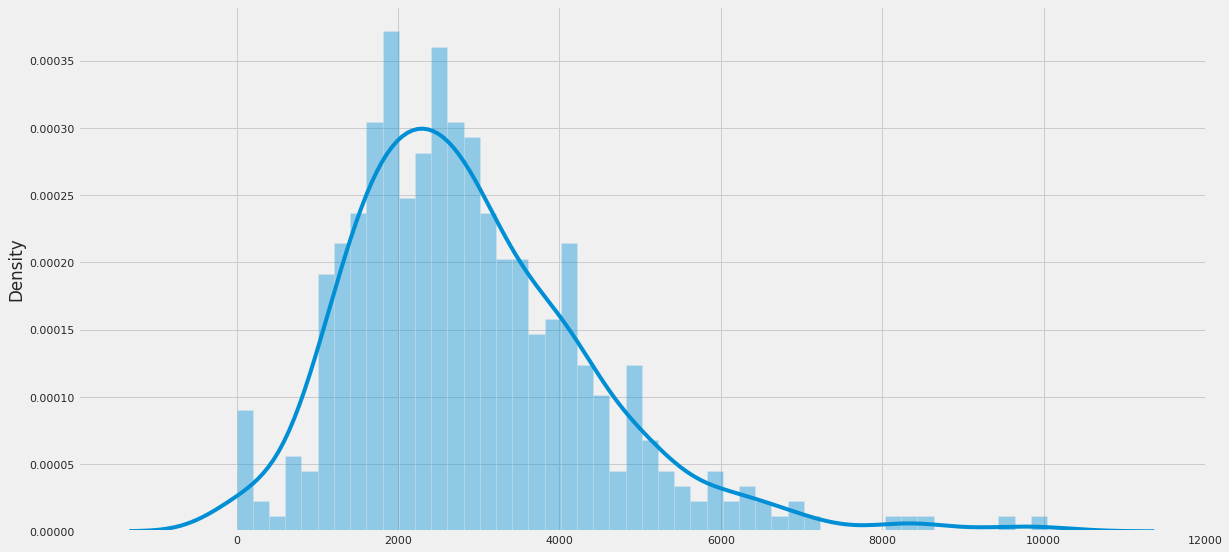

In [91]:
print(proc_testimony_df.shape)
sns.distplot(proc_testimony_df["word_count"].values, bins=50)

In [92]:
# Check records where speaker is null
proc_testimony_df['speaker'].isnull().sum()

0

In [93]:
# Remove sections having less than 50 words because those are unlikely to contain meaningful sentences.
proc_testimony_df = remove_short_section(proc_testimony_df, min_words=50)
proc_testimony_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,testimony,1996-06-26,Supervision of bank sales practices,"Governor Edward W. Kelley, Jr.",2071,<NA>,None,1996-07-03,<NA>,None,It is a pleasure to appear before this Subcommittee to discuss the supervision of bank sales practices on behalf of the Federal Reserve. The recent publication of various survey results h...,"[, , , , It is a pleasure to appear before this Subcommittee to discuss the supervision of bank sales practices on behalf of the Federal Reserve. The recent publication of various survey ...",\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nIt is a pleasure to appear before this Subcommittee to discuss\r\n\r\n the supervision of bank sales practices on behalf of ...
1,testimony,1996-07-17,"""Prime bank"" schemes","Herbert A. Biern, Deputy Associate Director, Division of Banking Supervision and Regulation",959,<NA>,None,1996-08-20,<NA>,None,"I am pleased to appear before the Committee on Banking, Housing, and Urban Affairs to discuss actions that the Federal Reserve has taken over the past several years to address the problem ...","[, , , , I am pleased to appear before the Committee on Banking, Housing, and Urban Affairs to discuss actions that the Federal Reserve has taken over the past several years to address the...","\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI am pleased to appear before the Committee on Banking, Housing,\r\n\r\n and Urban Affairs to discuss actions that the Feder..."
2,testimony,1996-07-18,The Federal Reserve's semiannual monetary report,Chairman Alan Greenspan,2966,<NA>,None,1996-08-20,<NA>,None,"Before I take this opportunity to discuss the performance of the U.S.economy and the conduct of monetary policy, I would first like to thank theChairman and the other members of this Committee for...","[Testimony of Chairman Alan GreenspanThe Federal Reserve's semiannual monetary policy reportBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate July 18, 1996, Before I take th...","Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nJuly 18, 1996\n\n[SECT..."
3,testimony,1996-07-24,Trends in consumer lending,Governor Janet L. Yellen,2601,<NA>,None,1996-08-20,<NA>,None,I am pleased to appear before this Subcommittee today to discuss trendsin consumer lending and the Federal Reserve Board's view of how recentdevelopments in this sector are affecting U.S. commerci...,"[, , , , I am pleased to appear before this Subcommittee today to discuss trendsin consumer lending and the Federal Reserve Board's view of how recentdevelopments in this sector are affecting U.S....",\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI am pleased to appear before this Subcommittee today to discuss trends\r\n\r\nin consumer lending and the Federal Reserve Board...
4,testimony,1996-07-26,Recent reports on Federal Reserve operations,Chairman Alan Greenspan,3308,<NA>,None,1996-08-20,<NA>,None,"We are strongly committed to ensuring that the Federal Reserve Systemis managed efficiently and effectively. It is most important to us at the FederalReserve Board and the Reserve Banks, not only...","[, , , , I appreciate this opportunity to appear before the Banking Committeetoday to address certain recent reports on the Federal Reserve´s operations. Of mostrelevance, the GAO has raised some...",\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI appreciate this opportunity to appear before the Banking Committee\r\n\r\ntoday to address certain recent reports on the Feder...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
437,testimony,2020-06-30,Coronavirus and CARES Act,Chair Jerome H. Powell,2759,<NA>,None,2020-07-29,<NA>,None,"We meet as the pandemic continues to cause tremendous hardship, ta

In [94]:
# Extract Chairperson's speech
tmp_list = []
for i, row in proc_testimony_df.iterrows():
    chairperson = get_chairperson(row['date'])
    if chairperson.lower().split()[-1] in row['speaker'].lower():
        row['speaker'] = chairperson
        tmp_list.append(list(row))

col_names = proc_testimony_df.columns
testimony_chair_df = pd.DataFrame(data=tmp_list, columns=col_names)
testimony_chair_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,testimony,1996-07-18,The Federal Reserve's semiannual monetary report,Alan Greenspan,2966,<NA>,None,1996-08-20,<NA>,None,"Before I take this opportunity to discuss the performance of the U.S.economy and the conduct of monetary policy, I would first like to thank theChairman and the other members of this Committee for...","[Testimony of Chairman Alan GreenspanThe Federal Reserve's semiannual monetary policy reportBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate July 18, 1996, Before I take th...","Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nJuly 18, 1996\n\n[SECT..."
1,testimony,1996-07-26,Recent reports on Federal Reserve operations,Alan Greenspan,3308,<NA>,None,1996-08-20,<NA>,None,"We are strongly committed to ensuring that the Federal Reserve Systemis managed efficiently and effectively. It is most important to us at the FederalReserve Board and the Reserve Banks, not only...","[, , , , I appreciate this opportunity to appear before the Banking Committeetoday to address certain recent reports on the Federal Reserve´s operations. Of mostrelevance, the GAO has raised some...",\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI appreciate this opportunity to appear before the Banking Committee\r\n\r\ntoday to address certain recent reports on the Feder...
2,testimony,1997-01-21,"January 21, 1997",Alan Greenspan,2854,<NA>,None,1997-02-05,<NA>,None,"Mr. Chairman and members of the Committee, I am pleased to appear here today. In just a few weeks the Federal Reserve Board will submit its semiannual report on monetary policy to the Congress. ...","[Testimony of Chairman Alan GreenspanPerformance of the U.S. economyBefore the Committee on the Budget, United States SenateJanuary 21, 1997, Mr. Chairman and members of the Committee, I am please...","Testimony of Chairman Alan Greenspan\nPerformance of the U.S. economy\r\nBefore the Committee on the Budget, United States Senate\r\nJanuary 21, 1997\n\n[SECTION]\n\nMr. Chairman and members of th..."
3,testimony,1997-01-30,The comsumer price index,Alan Greenspan,2692,<NA>,None,1997-02-05,<NA>,None,"Mr. Chairman and members of the Committee, I appreciate the opportunity to appear before you today. The Committee is faced with a number of complex policy issues that will have an important beari...","[Testimony of Chairman Alan GreenspanThe consumer price indexBefore the Committee on Finance, United States SenateJanuary 30, 1997, Mr. Chairman and members of the Committee, I appreciate the oppo...","Testimony of Chairman Alan Greenspan\nThe consumer price index\r\nBefore the Committee on Finance, United States Senate\r\nJanuary 30, 1997\n\n[SECTION]\n\nMr. Chairman and members of the Committe..."
4,testimony,1997-02-13,Modernization of the financial system,Alan Greenspan,4100,<NA>,None,1997-03-25,<NA>,None,"Madam Chairwoman, members of the Subcommittee on Financial Institutions and Consumer Credit, it is a pleasure to appear here today to present the views of the Federal Reserve Board on some broad i...","[Testimony of Chairman Alan GreenspanModernization of the financial systemBefore the Subcommittee on Financial Institutions and Consumer Credit\tof the Committee on Banking and Financial Services,...",Testimony of Chairman Alan Greenspan\nModernization of the financial system\r\nBefore the Subcommittee on Financial Institutions and Consumer Credit\r\n\tof the Committee on Banking and Financial ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,testimony,2020-02-11,Semiannual Monetary Policy Report to the Congress,Jerome Powell,1171,<NA>,None,2020-03-03,<NA>,None,My colleagues and I strongly support the goals of maximum employment and price stability that Congress has set for monetary policy. Congr

### Split contents to max 200 words

In [95]:
testimony_split_df = get_split_df(testimony_chair_df)
testimony_split_df.reset_index(drop=True, inplace=True)
print(testimony_split_df.shape)
testimony_split_df


           type  ...                                                                                                                                                                                                 org_text
0     testimony  ...  Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nJuly 18, 1996\n\n[SECT...
1     testimony  ...  Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nJuly 18, 1996\n\n[SECT...
2     testimony  ...  Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nJuly 18, 1996\n\n[SECT...
3     testimony  ...  Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy re

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,testimony,1996-07-18,The Federal Reserve's semiannual monetary report,Alan Greenspan,200,<NA>,None,1996-08-20,<NA>,None,Before I take this opportunity to discuss the performance of the U S economy and the conduct of monetary policy I would first like to thank theChairman and the other members of this Committee for ...,"[Testimony of Chairman Alan GreenspanThe Federal Reserve's semiannual monetary policy reportBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate July 18, 1996, Before I take th...","Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nJuly 18, 1996\n\n[SECT..."
1,testimony,1996-07-18,The Federal Reserve's semiannual monetary report,Alan Greenspan,200,<NA>,None,1996-08-20,<NA>,None,above their postwar averages About million workers have beenadded to nonfarm payrolls in the first six months of the year and theunemployment rate fell to percent in June Even though the U S econo...,"[Testimony of Chairman Alan GreenspanThe Federal Reserve's semiannual monetary policy reportBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate July 18, 1996, Before I take th...","Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nJuly 18, 1996\n\n[SECT..."
2,testimony,1996-07-18,The Federal Reserve's semiannual monetary report,Alan Greenspan,200,<NA>,None,1996-08-20,<NA>,None,be better than manyanalysts expected An important supporting factor as I pointed out in February wasfavorable conditions in financial markets in the latter part of and early Intermediate and longe...,"[Testimony of Chairman Alan GreenspanThe Federal Reserve's semiannual monetary policy reportBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate July 18, 1996, Before I take th...","Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nJuly 18, 1996\n\n[SECT..."
3,testimony,1996-07-18,The Federal Reserve's semiannual monetary report,Alan Greenspan,200,<NA>,None,1996-08-20,<NA>,None,better than those of many ofour major trading partners The rise in the dollar helps to keep down pricepressures but it also tends to divert domestic demand toward imported goods anddamp exports so...,"[Testimony of Chairman Alan GreenspanThe Federal Reserve's semiannual monetary policy reportBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate July 18, 1996, Before I take th...","Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nJuly 18, 1996\n\n[SECT..."
4,testimony,1996-07-18,The Federal Reserve's semiannual monetary report,Alan Greenspan,200,<NA>,None,1996-08-20,<NA>,None,less rapidly asfinal demand slows some While these are all good reasons to anticipate that economic growth willmoderate some the timing and extent of that downshift are uncertain We havenot as yet...,"[Testimony of Chairman Alan GreenspanThe Federal Reserve's semiannual monetary policy reportBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate July 18, 1996, Before I take th...","Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nJuly 18, 1996\n\n[SECT..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2829,testimony,2020-09-22,"Coronavirus Aid, Relief, and Economic Security Act",Jerome Powell,200,<NA>,None,2020-11-05,<NA>,None,U S companies so that they can maintain business operations and capacit

### Filter out by keyword

In [96]:
# Keep sections having keywords and long enough
testimony_keyword_df = remove_short_nokeyword(testimony_chair_df)
testimony_keyword_df.reset_index(drop=True, inplace=True)
print(testimony_keyword_df.shape)
testimony_keyword_df


(124, 13)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,testimony,1996-07-18,The Federal Reserve's semiannual monetary report,Alan Greenspan,628,<NA>,None,1996-08-20,<NA>,None,"Even though the U.S. economy is using its productive resources intensively,inflation has remained quiescent. The core inflation rate, measured by the consumerprice index less food and energy pric...","[Even though the U.S. economy is using its productive resources intensively,inflation has remained quiescent. The core inflation rate, measured by the consumerprice index less food and energy pri...","Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nJuly 18, 1996\n\n[SECT..."
1,testimony,1997-01-21,"January 21, 1997",Alan Greenspan,549,<NA>,None,1997-02-05,<NA>,None,"Mr. Chairman and members of the Committee, I am pleased to appear here today. In just a few weeks the Federal Reserve Board will submit its semiannual report on monetary policy to the Congress. ...","[Mr. Chairman and members of the Committee, I am pleased to appear here today. In just a few weeks the Federal Reserve Board will submit its semiannual report on monetary policy to the Congress. ...","Testimony of Chairman Alan Greenspan\nPerformance of the U.S. economy\r\nBefore the Committee on the Budget, United States Senate\r\nJanuary 21, 1997\n\n[SECTION]\n\nMr. Chairman and members of th..."
2,testimony,1997-02-26,The Federal Reserve's semiannual monetary policy report,Alan Greenspan,286,<NA>,None,1997-03-25,<NA>,None,"The performance of the U.S. economy over the past year has been quite favorable. Real GDP growth picked up to more than three percent over the four quarters of 1996, as the economy progr...","[The performance of the U.S. economy over the past year has been quite favorable. Real GDP growth picked up to more than three percent over the four quarters of 1996, as the economy prog...","Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nFebruary 26, 1997\n\n[..."
3,testimony,1997-03-20,Performance of the U.S. economy,Alan Greenspan,160,<NA>,None,1997-03-25,<NA>,None,"Indeed, the labor markets bear especially careful watching for signs that such a process is under way. So far this year, the demand for labor has stayed strong. Payroll employment grew briskly i...","[Indeed, the labor markets bear especially careful watching for signs that such a process is under way. So far this year, the demand for labor has stayed strong. Payroll employment grew briskly ...","Testimony of Chairman Alan Greenspan\nPerformance of the U.S. economy\r\nJoint Economic Committee, United States Congress\r\n\r\nMarch 20, 1997\n\n[SECTION]\n\n\n\n[SECTION]\n\nMr. Chairman and me..."
4,testimony,1997-07-22,The Federal Reserve's semiannual monetary policy report,Alan Greenspan,1068,<NA>,None,1997-08-19,<NA>,None,This strong expansion has produced a remarkable increase in work opportunities for Americans. A net of more than thirteen million jobs has been created since the ...,[This strong expansion has produced a remarkable increase in work opportunities for Americans. A net of more than thirteen million jobs has been created since the ...,"Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nJuly 22, 1997\n\n[SECT..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,testimony,2019-11-13,The Economic Outlook,Jerome Powell,776,<NA>,None,2019-12-11,<NA>,None,"Chairman Lee, Vice Chair Maloney, and members of the Committee, I appreciate the opportunity to testify before you today. Let me start by saying that my colleagues and I strongly support the goals...","[Chairman Lee, Vice Cha

In [97]:
# Drop text sections
testimony_chair_df.drop(columns=['text_sections', 'org_text'], inplace=True)
testimony_split_df.drop(columns=['text_sections', 'org_text'], inplace=True)
testimony_keyword_df.drop(columns=['text_sections', 'org_text'], inplace=True)

## Save the train data

In [98]:
# Combine dataframes
text_no_split = pd.concat([proc_statement_df, 
                           proc_minutes_df, 
                           presconf_script_chair_day_df, 
                           meeting_script_speaker_df, 
                           speech_chair_df,
                           testimony_chair_df], sort=False)
text_no_split.reset_index(drop=True, inplace=True)

text_split_200 = pd.concat([split_statement_df, 
                            split_minutes_df, 
                            presconf_script_split_df, 
                            meeting_script_split_df, 
                            speech_split_df, 
                            testimony_split_df], sort=False)
text_split_200.reset_index(drop=True, inplace=True)

text_keyword = pd.concat([keyword_statement_df,
                          keyword_minutes_df,
                          presconf_script_keyword_df,
                          meeting_script_keyword_df, 
                          speech_keyword_df, 
                          testimony_keyword_df], sort=False)
text_keyword.reset_index(drop=True, inplace=True)

In [99]:
def save_data(df, file_name, dir_name=preprocessed_dir):
  if not os.path.exists(dir_name):
    os.mkdir(dir_name)

  # Save results to a picke file
  file = open(dir_name + file_name + '.pickle', 'wb')
  pickle.dump(df, file)
  file.close()
  print("Data Saved to a pickle file in {} !".format(dir_name))
  
  # Save results to a csv file
  #df.to_csv(dir_name + file_name + '.csv', index=True)
  #print("Data Saved to a csv file in {} !".format(dir_name))

In [100]:
save_data(text_no_split, 'text_no_split')

Data Saved to a pickle file in /content/drive/My Drive/Colab Notebooks/proj2/src/data/preprocessed/ !


In [101]:
save_data(text_split_200, 'text_split_200')

Data Saved to a pickle file in /content/drive/My Drive/Colab Notebooks/proj2/src/data/preprocessed/ !


In [102]:
save_data(text_keyword, 'text_keyword')

Data Saved to a pickle file in /content/drive/My Drive/Colab Notebooks/proj2/src/data/preprocessed/ !
